# Idea
Do some training

In [1]:
SEED = 133
TIME_WINDOW = "40s"
DATA_FILE = '../../data/all_df_40s_Heqing_device2.csv'

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pickle

assert Path(DATA_FILE).exists()

In [3]:
import sys
repo_base_path = Path("./../../../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))
sys.path.append("..")

# from py_dataset import get_all_files_df
# from py_dataset import read_in_files
from py_dataset import feature_plotting
# from py_dataset import feature_selection
# from py_dataset import net_feature_engineering
# from py_dataset import entropy_feature_engineering
# from py_dataset.classes import DataSource
from py_dataset import sys_func

from py_dataset.classes import DataSource



In [4]:
LOG_PATH = (repo_base_path / "training" / "official_logs")
LOG_NAME = f"single-layer_300_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_2 = f"single-layer_30_from_weights_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_3 = f"multi-layer_30_from_weights_{TIME_WINDOW}"

assert LOG_PATH.exists()
assert not (LOG_PATH / LOG_NAME).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_2).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_3).exists(), "are you sure to run this again?"

In [5]:
df = pd.read_csv(DATA_FILE)
df.set_index("timestamp", inplace=True)

In [6]:
assert df["label"].unique().shape == (10,)

### Preprocessings
- remove Null values
- drop timestamp
- labelEncode
- normalize

In [7]:
print(df.shape)
old_df = df.copy()
df.dropna(axis=0, how='any', inplace=True)

print(df.shape)

(21673, 306)
(16515, 306)


In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.transform(df['label'])

In [10]:
df = feature_plotting.test_transform_all_to_numeric_columns(df)

In [11]:
cols_to_exclude_from_scaling = ["label"]
vectors = feature_plotting.minmax_scale_features(df,remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)
# print(vectors.shape)
# print(" with dropped null: ", vectors.dropna(axis=0, how='any', inplace=False).shape)

In [12]:
df["label"].unique(), vectors["label"].unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

### Setup

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomeDataset(Dataset):
    def __init__(self, some_df:pd.DataFrame):
        
        self.x = torch.tensor(some_df.drop(columns=["label"], inplace=False).values, dtype=torch.float32)
        self.labels = torch.tensor(some_df["label"].values, dtype=torch.uint8)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # print(self.x[idx], self.labels[idx])
        return self.x[idx], self.labels[idx]

In [14]:
from mlp_single_layer import MalwaresModelLinearLayer
from torch.utils.data import DataLoader
import lightning
from sklearn.model_selection import train_test_split
from lightning import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)

# split into train and val
train, val = train_test_split(vectors, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 2.8 K 
------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[107,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 82,   0,   0,   0,   8,   0,   0,  19,   0],
        [134,   0,   0,   0,   0,   0,   0,   2,   0],
        [111,   0,   0,   0,   0,   0,   0,   2,   0],
        [106,   0,   0,   0,   0,   0,   0,   1,   0],
        [111,   0,   0,   0,   0,   0,   0,   0,   0],
        [104,   0,   1,   0,   0,   0,   0,   0,   0],
        [101,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 111,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 188,    1,  293,  598,  595,    0,  162,    0,    0],
        [ 124, 1775,    0,    0,   14,    0,    0,   21,    0],
        [ 232,   43, 1368,   92,  305,  133,  120,    3,    0],
        [ 191,    2,  346,  772,  444,    1,  150,    7,    0],
        [ 165,    5,  210,  166, 1264,   15,   86,    1,    0],
        [ 163,  116,   62,    0,    1, 1556,    0,    3,    0],
        [ 177,   13,  897,  169,  369,  102,  183,    0,    0],
        [ 161,    0,    0,    0,    0,    0,    0, 1740,    0],
        [   3,    2,   49,   17,    0,    0,    0,  201, 1639]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[ 188,    1,  293,  598,  595,    0,  162,    0,    0],
        [ 124, 1775,    0,    0,   14,    0,    0,   21,    0],
        [ 232,   43, 1368,   92,  305,  133,  120,    3,    0],
        [ 191,    2,  346,  772,  444,    1,  150,    7,    0],
        [ 165,    5,  210,  166, 1264,   15,   86,    1,   

Metric Validation/Accuracy improved. New best score: 0.683


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[ 778,    1,  441, 1088,  933,    0,  326,    0,    0],
        [ 124, 3600,    0,    0,   14,    0,    0,   21,    0],
        [ 357,   43, 2994,  148,  473,  167,  271,    3,    0],
        [ 402,    2,  588, 1731,  684,    1,  293,   12,    0],
        [ 272,    5,  315,  226, 2673,   30,  195,    1,    0],
        [ 163,  116,   66,    0,    1, 3342,    0,    3,    0],
        [ 364,   13, 1734,  284,  607,  130,  583,    0,    0],
        [ 161,    0,    0,    0,    0,    0,    0, 3540,    0],
        [   3,    2,   49,   17,    0,    0,    0,  201, 3439]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[ 778,    1,  441, 1088,  933,    0,  326,    0,    0],
        [ 124, 3600,    0,    0,   14,    0,    0,   21,    0],
        [ 357,   43, 2994,  148,  473,  167,  271,    3,    0],
        [ 402,    2,  588, 1731,  684,    1,  293,   12,    0],
        [ 272,    5,  315,  226, 2673,   30,  195,    1,   

Metric Validation/Accuracy improved by 0.080 >= min_delta = 0.0. New best score: 0.763


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[1647,    1,  477, 1632, 1014,    0,  526,    0,    0],
        [ 124, 5425,    0,    0,   14,    0,    0,   21,    0],
        [ 495,   43, 4648,  209,  565,  188,  465,    3,    0],
        [ 652,    2,  730, 2925,  743,    1,  443,   17,    0],
        [ 351,    5,  357,  282, 4181,   43,  302,    1,    0],
        [ 163,  116,   72,    0,    1, 5126,    0,    3,    0],
        [ 553,   13, 2387,  430,  752,  141, 1244,    0,    0],
        [ 161,    0,    0,    0,    0,    0,    0, 5340,    0],
        [   3,    2,   49,   17,    0,    0,    0,  201, 5239]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[1647,    1,  477, 1632, 1014,    0,  526,    0,    0],
        [ 124, 5425,    0,    0,   14,    0,    0,   21,    0],
        [ 495,   43, 4648,  209,  565,  188,  465,    3,    0],
        [ 652,    2,  730, 2925,  743,    1,  443,   17,    0],
        [ 351,    5,  357,  282, 4181,   43,  302,    1,   

Metric Validation/Accuracy improved by 0.044 >= min_delta = 0.0. New best score: 0.807


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[2776,    1,  488, 2058, 1035,    0,  669,    0,    0],
        [ 124, 7250,    0,    0,   14,    0,    0,   21,    0],
        [ 628,   43, 6348,  252,  609,  208,  685,    3,    0],
        [ 959,    2,  812, 4170,  763,    1,  585,   21,    0],
        [ 393,    5,  370,  320, 5816,   54,  368,    1,    0],
        [ 163,  116,   77,    0,    1, 6911,    0,    3,    0],
        [ 737,   13, 2993,  573,  844,  147, 2018,    0,    0],
        [ 161,    0,    0,    0,    0,    0,    0, 7140,    0],
        [   3,    2,   49,   17,    0,    0,    0,  201, 7039]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[2776,    1,  488, 2058, 1035,    0,  669,    0,    0],
        [ 124, 7250,    0,    0,   14,    0,    0,   21,    0],
        [ 628,   43, 6348,  252,  609,  208,  685,    3,    0],
        [ 959,    2,  812, 4170,  763,    1,  585,   21,    0],
        [ 393,    5,  370,  320, 5816,   54,  368,    1,   

Metric Validation/Accuracy improved by 0.029 >= min_delta = 0.0. New best score: 0.836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[3874,    1,  501, 2512, 1040,    0,  829,    0,    0],
        [ 124, 9075,    0,    0,   14,    0,    0,   21,    0],
        [ 712,   43, 8080,  310,  618,  224,  946,    3,    0],
        [1223,    2,  882, 5474,  773,    1,  732,   26,    0],
        [ 419,    5,  381,  347, 7506,   64,  409,    1,    0],
        [ 163,  116,   80,    0,    1, 8698,    0,    3,    0],
        [ 869,   13, 3585,  743,  902,  149, 2869,    0,    0],
        [ 161,    0,    0,    0,    0,    0,    0, 8940,    0],
        [   3,    2,   49,   17,    0,    0,    0,  201, 8839]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[3874,    1,  501, 2512, 1040,    0,  829,    0,    0],
        [ 124, 9075,    0,    0,   14,    0,    0,   21,    0],
        [ 712,   43, 8080,  310,  618,  224,  946,    3,    0],
        [1223,    2,  882, 5474,  773,    1,  732,   26,    0],
        [ 419,    5,  381,  347, 7506,   64,  409,    1,   

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.837


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 5173,     1,   502,  2854,  1040,     0,   917,     0,     0],
        [  124, 10900,     0,     0,    14,     0,     0,    21,     0],
        [  815,    43,  9815,   350,   618,   237,  1215,     3,     0],
        [ 1628,     2,   917,  6677,   777,     1,   885,    26,     0],
        [  453,     5,   384,   369,  9229,    71,   425,     1,     0],
        [  163,   116,    85,     0,     1, 10483,     0,     3,     0],
        [ 1024,    13,  4117,   885,   933,   149,  3814,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 10740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 10639]])
Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 5173,     1,   502,  2854,  1040,     0,   917,     0,     0],
        [  124, 10900,     0,     0,    14,     0,     0,    21,     0],
        [  815,    43,  9815,   350,   618,   237,  1215,     3,     0],
        [ 1628,

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.840


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 6304,     1,   502,  3336,  1041,     0,  1033,     0,     0],
        [  124, 12725,     0,     0,    14,     0,     0,    21,     0],
        [  885,    43, 11529,   396,   618,   250,  1532,     3,     0],
        [ 1933,     2,   948,  7994,   782,     1,  1027,    26,     0],
        [  482,     5,   384,   386, 10976,    76,   432,     1,     0],
        [  163,   116,    88,     0,     1, 12270,     0,     3,     0],
        [ 1150,    13,  4574,  1054,   954,   149,  4846,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 12540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 12439]])


Metric Validation/Accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.860


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 6304,     1,   502,  3336,  1041,     0,  1033,     0,     0],
        [  124, 12725,     0,     0,    14,     0,     0,    21,     0],
        [  885,    43, 11529,   396,   618,   250,  1532,     3,     0],
        [ 1933,     2,   948,  7994,   782,     1,  1027,    26,     0],
        [  482,     5,   384,   386, 10976,    76,   432,     1,     0],
        [  163,   116,    88,     0,     1, 12270,     0,     3,     0],
        [ 1150,    13,  4574,  1054,   954,   149,  4846,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 12540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 12439]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 7680,     1,   502,  3619,  1042,     0,  1103,     0,     0],
        [  124, 14550,     0,     0,    14,     0,     0,    21,     0],
        [  938,    43, 13256,   434,   618,   262,  1862,     3,     0],
        [ 2226,     2,   981,  9332,   782,     1,  1163,    26,     0],
        [  488,     5,   384,   404, 12746,    81,   438,     1,     0],
        [  163,   116,    93,     0,     1, 14055,     0,     3,     0],
        [ 1261,    13,  5074,  1200,   978,   149,  5870,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 14340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 14239]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 7680,     1,   502,  3619,  1042,     0,  1103,     0,     0],
        [  124, 14550,     0,     0,    14,     0,     0,    21,     0],
        [  938,    43, 13256,   434,   618,   262,  1862,     3,     0],
        [ 2226,

Metric Validation/Accuracy improved by 0.022 >= min_delta = 0.0. New best score: 0.882


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 9005,     1,   502,  3954,  1042,     0,  1173,     0,     0],
        [  124, 16375,     0,     0,    14,     0,     0,    21,     0],
        [  971,    43, 15016,   468,   618,   271,  2186,     3,     0],
        [ 2447,     2,  1004, 10760,   784,     1,  1289,    26,     0],
        [  507,     5,   384,   412, 14516,    86,   441,     1,     0],
        [  163,   116,    95,     0,     1, 15843,     0,     3,     0],
        [ 1346,    13,  5542,  1351,   990,   149,  6959,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 16140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 16039]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[ 9005,     1,   502,  3954,  1042,     0,  1173,     0,     0],
        [  124, 16375,     0,     0,    14,     0,     0,    21,     0],
        [  971,    43, 15016,   468,   618,   271,  2186,     3,     0],
        [ 2447,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[10490,     1,   502,  4159,  1042,     0,  1213,     0,     0],
        [  124, 18200,     0,     0,    14,     0,     0,    21,     0],
        [ 1016,    43, 16777,   497,   618,   275,  2507,     3,     0],
        [ 2747,     2,  1020, 12113,   784,     1,  1420,    26,     0],
        [  517,     5,   384,   417, 16298,    91,   444,     1,     0],
        [  163,   116,    96,     0,     1, 17632,     0,     3,     0],
        [ 1455,    13,  5968,  1488,   999,   149,  8083,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 17940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 17839]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.885


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[10490,     1,   502,  4159,  1042,     0,  1213,     0,     0],
        [  124, 18200,     0,     0,    14,     0,     0,    21,     0],
        [ 1016,    43, 16777,   497,   618,   275,  2507,     3,     0],
        [ 2747,     2,  1020, 12113,   784,     1,  1420,    26,     0],
        [  517,     5,   384,   417, 16298,    91,   444,     1,     0],
        [  163,   116,    96,     0,     1, 17632,     0,     3,     0],
        [ 1455,    13,  5968,  1488,   999,   149,  8083,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 17940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 17839]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[11929,     1,   502,  4400,  1042,     0,  1263,     0,     0],
        [  124, 20025,     0,     0,    14,     0,     0,    21,     0],
        [ 1041,    43, 18525,   526,   618,   283,  2857,     3,     0],
        [ 2960,     2,  1037, 13555,   784,     1,  1548,    26,     0],
        [  524,     5,   384,   424, 18082,    96,   446,     1,     0],
        [  163,   116,    99,     0,     1, 19419,     0,     3,     0],
        [ 1537,    13,  6362,  1630,  1008,   149,  9261,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 19740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 19639]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[11929,     1,   502,  4400,  1042,     0,  1263,     0,     0],
        [  124, 20025,     0,     0,    14,     0,     0,    21,     0],
        [ 1041,    43, 18525,   526,   618,   283,  2857,     3,     0],
        [ 296

Metric Validation/Accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.898


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[13430,     1,   502,  4608,  1042,     0,  1284,     0,     0],
        [  124, 21850,     0,     0,    14,     0,     0,    21,     0],
        [ 1061,    43, 20329,   551,   618,   286,  3165,     3,     0],
        [ 3167,     2,  1061, 15042,   784,     1,  1630,    26,     0],
        [  527,     5,   384,   429, 19874,   101,   446,     1,     0],
        [  163,   116,   102,     0,     1, 21206,     0,     3,     0],
        [ 1622,    13,  6830,  1787,  1013,   149, 10351,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 21540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 21439]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[13430,     1,   502,  4608,  1042,     0,  1284,     0,     0],
        [  124, 21850,     0,     0,    14,     0,     0,    21,     0],
        [ 1061,    43, 20329,   551,   618,   286,  3165,     3,     0],
        [ 316

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[14963,     1,   502,  4775,  1042,     0,  1314,     0,     0],
        [  124, 23675,     0,     0,    14,     0,     0,    21,     0],
        [ 1085,    43, 22129,   571,   618,   286,  3481,     3,     0],
        [ 3438,     2,  1090, 16450,   784,     1,  1722,    26,     0],
        [  532,     5,   384,   434, 21664,   106,   446,     1,     0],
        [  163,   116,   104,     0,     1, 22994,     0,     3,     0],
        [ 1721,    13,  7276,  1917,  1019,   149, 11475,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 23340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 23239]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[14963,     1,   502,  4775,  1042,     0,  1314,     0,     0],
        [  124, 23675,     0,     0,    14,     0,     0,    21,     0],
        [ 1085,    43, 22129,   571,   618,   286,  3481,     3,     0],
        [ 343

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[16457,     1,   502,  4980,  1042,     0,  1345,     0,     0],
        [  124, 25500,     0,     0,    14,     0,     0,    21,     0],
        [ 1101,    43, 23913,   588,   618,   289,  3821,     3,     0],
        [ 3631,     2,  1101, 17943,   784,     1,  1825,    26,     0],
        [  535,     5,   384,   439, 23456,   111,   446,     1,     0],
        [  163,   116,   106,     0,     1, 24782,     0,     3,     0],
        [ 1788,    13,  7660,  2068,  1024,   149, 12673,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 25140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 25039]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[16457,     1,   502,  4980,  1042,     0,  1345,     0,     0],
        [  124, 25500,     0,     0,    14,     0,     0,    21,     0],
        [ 1101,    43, 23913,   588,   618,   289,  3821,     3,     0],
        [ 363

Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.909


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[18017,     1,   502,  5123,  1042,     0,  1372,     0,     0],
        [  124, 27325,     0,     0,    14,     0,     0,    21,     0],
        [ 1119,    43, 25699,   601,   618,   289,  4164,     3,     0],
        [ 3839,     2,  1105, 19427,   784,     1,  1929,    26,     0],
        [  535,     5,   384,   444, 25253,   114,   446,     1,     0],
        [  163,   116,   106,     0,     1, 26572,     0,     3,     0],
        [ 1858,    13,  8019,  2204,  1029,   149, 13908,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 26940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 26839]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.913


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[18017,     1,   502,  5123,  1042,     0,  1372,     0,     0],
        [  124, 27325,     0,     0,    14,     0,     0,    21,     0],
        [ 1119,    43, 25699,   601,   618,   289,  4164,     3,     0],
        [ 3839,     2,  1105, 19427,   784,     1,  1929,    26,     0],
        [  535,     5,   384,   444, 25253,   114,   446,     1,     0],
        [  163,   116,   106,     0,     1, 26572,     0,     3,     0],
        [ 1858,    13,  8019,  2204,  1029,   149, 13908,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 26940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 26839]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[19582,     1,   502,  5261,  1042,     0,  1399,     0,     0],
        [  124, 29150,     0,     0,    14,     0,     0,    21,     0],
        [ 1131,    43, 27515,   610,   618,   289,  4487,     3,     0],
        [ 4002,     2,  1116, 20962,   784,     1,  2020,    26,     0],
        [  536,     5,   384,   449, 27046,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 28362,     0,     3,     0],
        [ 1929,    13,  8414,  2360,  1035,   149, 15085,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 28740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 28639]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[19582,     1,   502,  5261,  1042,     0,  1399,     0,     0],
        [  124, 29150,     0,     0,    14,     0,     0,    21,     0],
        [ 1131,    43, 27515,   610,   618,   289,  4487,     3,     0],
        [ 400

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.913


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[21183,     1,   502,  5371,  1042,     0,  1418,     0,     0],
        [  124, 30975,     0,     0,    14,     0,     0,    21,     0],
        [ 1143,    43, 29335,   621,   618,   289,  4804,     3,     0],
        [ 4200,     2,  1122, 22467,   784,     1,  2111,    26,     0],
        [  536,     5,   384,   454, 28846,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 30152,     0,     3,     0],
        [ 1991,    13,  8777,  2500,  1040,   149, 16320,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 30540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 30439]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[21183,     1,   502,  5371,  1042,     0,  1418,     0,     0],
        [  124, 30975,     0,     0,    14,     0,     0,    21,     0],
        [ 1143,    43, 29335,   621,   618,   289,  4804,     3,     0],
        [ 420

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.919


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[22799,     1,   502,  5465,  1042,     0,  1438,     0,     0],
        [  124, 32800,     0,     0,    14,     0,     0,    21,     0],
        [ 1155,    43, 31149,   627,   618,   289,  5132,     3,     0],
        [ 4376,     2,  1128, 24001,   784,     1,  2195,    26,     0],
        [  536,     5,   384,   459, 30646,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 31942,     0,     3,     0],
        [ 2053,    13,  9107,  2645,  1045,   149, 17583,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 32340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 32239]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.920


Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[22799,     1,   502,  5465,  1042,     0,  1438,     0,     0],
        [  124, 32800,     0,     0,    14,     0,     0,    21,     0],
        [ 1155,    43, 31149,   627,   618,   289,  5132,     3,     0],
        [ 4376,     2,  1128, 24001,   784,     1,  2195,    26,     0],
        [  536,     5,   384,   459, 30646,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 31942,     0,     3,     0],
        [ 2053,    13,  9107,  2645,  1045,   149, 17583,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 32340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 32239]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[24326,     1,   502,  5644,  1042,     0,  1462,     0,     0],
        [  124, 34625,     0,     0,    14,     0,     0,    21,     0],
        [ 1167,    43, 32977,   632,   618,   289,  5447,     3,     0],
        [ 4550,     2,  1134, 25537,   784,     1,  2279,    26,     0],
        [  537,     5,   384,   464, 32445,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 33732,     0,     3,     0],
        [ 2105,    13,  9436,  2794,  1050,   149, 18853,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 34140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 34039]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[24326,     1,   502,  5644,  1042,     0,  1462,     0,     0],
        [  124, 34625,     0,     0,    14,     0,     0,    21,     0],
        [ 1167,    43, 32977,   632,   618,   289,  5447,     3,     0],
        [ 455

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[25865,     1,   502,  5813,  1042,     0,  1484,     0,     0],
        [  124, 36450,     0,     0,    14,     0,     0,    21,     0],
        [ 1179,    43, 34842,   633,   618,   289,  5729,     3,     0],
        [ 4697,     2,  1151, 27109,   784,     1,  2343,    26,     0],
        [  538,     5,   384,   469, 34244,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 35522,     0,     3,     0],
        [ 2156,    13,  9840,  2950,  1055,   149, 20042,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 35940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 35839]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[25865,     1,   502,  5813,  1042,     0,  1484,     0,     0],
        [  124, 36450,     0,     0,    14,     0,     0,    21,     0],
        [ 1179,    43, 34842,   633,   618,   289,  5729,     3,     0],
        [ 469

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[27495,     1,   502,  5892,  1042,     0,  1505,     0,     0],
        [  124, 38275,     0,     0,    14,     0,     0,    21,     0],
        [ 1191,    43, 36651,   635,   618,   289,  6066,     3,     0],
        [ 4855,     2,  1155, 28662,   784,     1,  2428,    26,     0],
        [  538,     5,   384,   472, 36046,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 37312,     0,     3,     0],
        [ 2205,    13, 10125,  3087,  1060,   149, 21371,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 37740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 37639]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[27495,     1,   502,  5892,  1042,     0,  1505,     0,     0],
        [  124, 38275,     0,     0,    14,     0,     0,    21,     0],
        [ 1191,    43, 36651,   635,   618,   289,  6066,     3,     0],
        [ 485

Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.929


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[29150,     1,   502,  5949,  1042,     0,  1523,     0,     0],
        [  124, 40100,     0,     0,    14,     0,     0,    21,     0],
        [ 1202,    43, 38551,   637,   618,   289,  6313,     3,     0],
        [ 5012,     2,  1173, 30228,   784,     1,  2487,    26,     0],
        [  538,     5,   384,   475, 37848,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 39102,     0,     3,     0],
        [ 2278,    13, 10544,  3224,  1065,   149, 22542,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 39540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 39439]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[29150,     1,   502,  5949,  1042,     0,  1523,     0,     0],
        [  124, 40100,     0,     0,    14,     0,     0,    21,     0],
        [ 1202,    43, 38551,   637,   618,   289,  6313,     3,     0],
        [ 501

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[30807,     1,   502,  6006,  1042,     0,  1539,     0,     0],
        [  124, 41925,     0,     0,    14,     0,     0,    21,     0],
        [ 1214,    43, 40433,   638,   618,   289,  6578,     3,     0],
        [ 5164,     2,  1184, 31801,   784,     1,  2551,    26,     0],
        [  538,     5,   384,   477, 39651,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 40892,     0,     3,     0],
        [ 2336,    13, 10880,  3359,  1070,   149, 23813,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 41340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 41239]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[30807,     1,   502,  6006,  1042,     0,  1539,     0,     0],
        [  124, 41925,     0,     0,    14,     0,     0,    21,     0],
        [ 1214,    43, 40433,   638,   618,   289,  6578,     3,     0],
        [ 516

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[32446,     1,   502,  6079,  1042,     0,  1557,     0,     0],
        [  124, 43750,     0,     0,    14,     0,     0,    21,     0],
        [ 1223,    43, 42272,   638,   618,   289,  6890,     3,     0],
        [ 5302,     2,  1190, 33379,   784,     1,  2629,    26,     0],
        [  538,     5,   384,   480, 41453,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 42682,     0,     3,     0],
        [ 2379,    13, 11159,  3496,  1075,   149, 25154,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 43140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 43039]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[32446,     1,   502,  6079,  1042,     0,  1557,     0,     0],
        [  124, 43750,     0,     0,    14,     0,     0,    21,     0],
        [ 1223,    43, 42272,   638,   618,   289,  6890,     3,     0],
        [ 530

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.935


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[34100,     1,   502,  6136,  1042,     0,  1576,     0,     0],
        [  124, 45575,     0,     0,    14,     0,     0,    21,     0],
        [ 1233,    43, 44149,   643,   618,   289,  7158,     3,     0],
        [ 5423,     2,  1197, 34978,   784,     1,  2702,    26,     0],
        [  538,     5,   384,   481, 43257,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 44472,     0,     3,     0],
        [ 2429,    13, 11466,  3632,  1080,   149, 26461,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 44940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 44839]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[34100,     1,   502,  6136,  1042,     0,  1576,     0,     0],
        [  124, 45575,     0,     0,    14,     0,     0,    21,     0],
        [ 1233,    43, 44149,   643,   618,   289,  7158,     3,     0],
        [ 542

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[35756,     1,   502,  6189,  1042,     0,  1597,     0,     0],
        [  124, 47400,     0,     0,    14,     0,     0,    21,     0],
        [ 1245,    43, 46004,   643,   618,   289,  7451,     3,     0],
        [ 5532,     2,  1201, 36598,   784,     1,  2769,    26,     0],
        [  538,     5,   384,   483, 45060,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 46262,     0,     3,     0],
        [ 2475,    13, 11714,  3762,  1085,   149, 27837,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 46740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 46639]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[35756,     1,   502,  6189,  1042,     0,  1597,     0,     0],
        [  124, 47400,     0,     0,    14,     0,     0,    21,     0],
        [ 1245,    43, 46004,   643,   618,   289,  7451,     3,     0],
        [ 553

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.939


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[37428,     1,   502,  6229,  1042,     0,  1615,     0,     0],
        [  124, 49225,     0,     0,    14,     0,     0,    21,     0],
        [ 1255,    43, 47882,   643,   618,   289,  7723,     3,     0],
        [ 5632,     2,  1209, 38235,   784,     1,  2824,    26,     0],
        [  538,     5,   384,   485, 46863,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 48052,     0,     3,     0],
        [ 2519,    13, 11976,  3889,  1089,   149, 29205,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 48540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 48439]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[37428,     1,   502,  6229,  1042,     0,  1615,     0,     0],
        [  124, 49225,     0,     0,    14,     0,     0,    21,     0],
        [ 1255,    43, 47882,   643,   618,   289,  7723,     3,     0],
        [ 563

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[39109,     1,   502,  6259,  1042,     0,  1634,     0,     0],
        [  124, 51050,     0,     0,    14,     0,     0,    21,     0],
        [ 1260,    43, 49775,   643,   618,   289,  7985,     3,     0],
        [ 5735,     2,  1219, 39854,   784,     1,  2892,    26,     0],
        [  538,     5,   384,   487, 48666,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 49842,     0,     3,     0],
        [ 2569,    13, 12230,  4009,  1093,   149, 30582,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 50340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 50239]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[39109,     1,   502,  6259,  1042,     0,  1634,     0,     0],
        [  124, 51050,     0,     0,    14,     0,     0,    21,     0],
        [ 1260,    43, 49775,   643,   618,   289,  7985,     3,     0],
        [ 573

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.940


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[40763,     1,   502,  6316,  1042,     0,  1653,     0,     0],
        [  124, 52875,     0,     0,    14,     0,     0,    21,     0],
        [ 1270,    43, 51671,   643,   618,   289,  8239,     3,     0],
        [ 5823,     2,  1228, 41497,   784,     1,  2952,    26,     0],
        [  538,     5,   384,   489, 50469,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 51632,     0,     3,     0],
        [ 2611,    13, 12471,  4132,  1097,   149, 31977,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 52140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 52039]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[40763,     1,   502,  6316,  1042,     0,  1653,     0,     0],
        [  124, 52875,     0,     0,    14,     0,     0,    21,     0],
        [ 1270,    43, 51671,   643,   618,   289,  8239,     3,     0],
        [ 582

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[42439,     1,   502,  6350,  1042,     0,  1673,     0,     0],
        [  124, 54700,     0,     0,    14,     0,     0,    21,     0],
        [ 1274,    43, 53588,   643,   618,   289,  8478,     3,     0],
        [ 5907,     2,  1236, 43151,   784,     1,  3006,    26,     0],
        [  538,     5,   384,   491, 52272,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 53422,     0,     3,     0],
        [ 2651,    13, 12743,  4265,  1102,   149, 33332,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 53940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 53839]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[42439,     1,   502,  6350,  1042,     0,  1673,     0,     0],
        [  124, 54700,     0,     0,    14,     0,     0,    21,     0],
        [ 1274,    43, 53588,   643,   618,   289,  8478,     3,     0],
        [ 590

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.942


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[44134,     1,   502,  6366,  1042,     0,  1692,     0,     0],
        [  124, 56525,     0,     0,    14,     0,     0,    21,     0],
        [ 1275,    43, 55483,   643,   618,   289,  8742,     3,     0],
        [ 6000,     2,  1244, 44793,   784,     1,  3063,    26,     0],
        [  538,     5,   384,   492, 54076,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 55212,     0,     3,     0],
        [ 2702,    13, 12971,  4383,  1104,   149, 34738,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 55740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 55639]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.944


Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[44134,     1,   502,  6366,  1042,     0,  1692,     0,     0],
        [  124, 56525,     0,     0,    14,     0,     0,    21,     0],
        [ 1275,    43, 55483,   643,   618,   289,  8742,     3,     0],
        [ 6000,     2,  1244, 44793,   784,     1,  3063,    26,     0],
        [  538,     5,   384,   492, 54076,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 55212,     0,     3,     0],
        [ 2702,    13, 12971,  4383,  1104,   149, 34738,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 55740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 55639]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[45820,     1,   502,  6391,  1042,     0,  1711,     0,     0],
        [  124, 58350,     0,     0,    14,     0,     0,    21,     0],
        [ 1278,    43, 57395,   643,   618,   289,  8987,     3,     0],
        [ 6098,     2,  1247, 46437,   784,     1,  3118,    26,     0],
        [  538,     5,   384,   493, 55880,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 57002,     0,     3,     0],
        [ 2748,    13, 13185,  4506,  1107,   149, 36157,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 57540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 57439]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[45820,     1,   502,  6391,  1042,     0,  1711,     0,     0],
        [  124, 58350,     0,     0,    14,     0,     0,    21,     0],
        [ 1278,    43, 57395,   643,   618,   289,  8987,     3,     0],
        [ 609

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[47500,     1,   502,  6423,  1042,     0,  1729,     0,     0],
        [  124, 60175,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 59324,   643,   618,   289,  9214,     3,     0],
        [ 6173,     2,  1251, 48115,   784,     1,  3161,    26,     0],
        [  538,     5,   384,   494, 57684,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 58792,     0,     3,     0],
        [ 2787,    13, 13424,  4643,  1110,   149, 37544,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 59340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 59239]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[47500,     1,   502,  6423,  1042,     0,  1729,     0,     0],
        [  124, 60175,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 59324,   643,   618,   289,  9214,     3,     0],
        [ 617

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[49198,     1,   502,  6434,  1042,     0,  1750,     0,     0],
        [  124, 62000,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 61244,   643,   618,   289,  9454,     3,     0],
        [ 6246,     2,  1252, 49784,   784,     1,  3218,    26,     0],
        [  538,     5,   384,   495, 59488,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 60582,     0,     3,     0],
        [ 2831,    13, 13644,  4761,  1110,   149, 38967,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 61140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 61039]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[49198,     1,   502,  6434,  1042,     0,  1750,     0,     0],
        [  124, 62000,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 61244,   643,   618,   289,  9454,     3,     0],
        [ 624

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[50876,     1,   502,  6468,  1042,     0,  1768,     0,     0],
        [  124, 63825,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 63181,   643,   618,   289,  9677,     3,     0],
        [ 6309,     2,  1253, 51477,   784,     1,  3261,    26,     0],
        [  538,     5,   384,   495, 61293,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 62372,     0,     3,     0],
        [ 2868,    13, 13865,  4893,  1110,   149, 40382,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 62940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 62839]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[50876,     1,   502,  6468,  1042,     0,  1768,     0,     0],
        [  124, 63825,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 63181,   643,   618,   289,  9677,     3,     0],
        [ 630

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[52567,     1,   502,  6490,  1042,     0,  1785,     0,     0],
        [  124, 65650,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 65109,   643,   618,   289,  9909,     3,     0],
        [ 6392,     2,  1254, 53148,   784,     1,  3306,    26,     0],
        [  538,     5,   384,   497, 63096,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 64162,     0,     3,     0],
        [ 2911,    13, 14065,  5019,  1110,   149, 41818,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 64740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 64639]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[52567,     1,   502,  6490,  1042,     0,  1785,     0,     0],
        [  124, 65650,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 65109,   643,   618,   289,  9909,     3,     0],
        [ 639

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[54266,     1,   502,  6501,  1042,     0,  1805,     0,     0],
        [  124, 67475,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 67042,   643,   618,   289, 10136,     3,     0],
        [ 6452,     2,  1255, 54841,   784,     1,  3352,    26,     0],
        [  538,     5,   384,   497, 64901,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 65952,     0,     3,     0],
        [ 2958,    13, 14256,  5136,  1110,   149, 43268,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 66540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 66439]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[54266,     1,   502,  6501,  1042,     0,  1805,     0,     0],
        [  124, 67475,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 67042,   643,   618,   289, 10136,     3,     0],
        [ 645

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[55959,     1,   502,  6520,  1042,     0,  1823,     0,     0],
        [  124, 69300,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 68973,   643,   618,   289, 10365,     3,     0],
        [ 6507,     2,  1257, 56537,   784,     1,  3399,    26,     0],
        [  538,     5,   384,   498, 66705,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 67742,     0,     3,     0],
        [ 2989,    13, 14438,  5261,  1110,   149, 44735,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 68340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 68239]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.953


Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[55959,     1,   502,  6520,  1042,     0,  1823,     0,     0],
        [  124, 69300,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 68973,   643,   618,   289, 10365,     3,     0],
        [ 6507,     2,  1257, 56537,   784,     1,  3399,    26,     0],
        [  538,     5,   384,   498, 66705,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 67742,     0,     3,     0],
        [ 2989,    13, 14438,  5261,  1110,   149, 44735,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 68340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 68239]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[57667,     1,   502,  6527,  1042,     0,  1838,     0,     0],
        [  124, 71125,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 70944,   643,   618,   289, 10554,     3,     0],
        [ 6567,     2,  1257, 58231,   784,     1,  3445,    26,     0],
        [  538,     5,   384,   498, 68510,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 69532,     0,     3,     0],
        [ 3029,    13, 14641,  5375,  1110,   149, 46183,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 70140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 70039]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[57667,     1,   502,  6527,  1042,     0,  1838,     0,     0],
        [  124, 71125,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 70944,   643,   618,   289, 10554,     3,     0],
        [ 656

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[59372,     1,   502,  6533,  1042,     0,  1857,     0,     0],
        [  124, 72950,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 72886,   643,   618,   289, 10772,     3,     0],
        [ 6622,     2,  1257, 59927,   784,     1,  3494,    26,     0],
        [  538,     5,   384,   498, 70315,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 71322,     0,     3,     0],
        [ 3066,    13, 14834,  5492,  1110,   149, 47641,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 71940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 71839]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[59372,     1,   502,  6533,  1042,     0,  1857,     0,     0],
        [  124, 72950,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 72886,   643,   618,   289, 10772,     3,     0],
        [ 662

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[61076,     1,   502,  6544,  1042,     0,  1872,     0,     0],
        [  124, 74775,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 74852,   643,   618,   289, 10966,     3,     0],
        [ 6676,     2,  1259, 61626,   784,     1,  3539,    26,     0],
        [  538,     5,   384,   498, 72120,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 73112,     0,     3,     0],
        [ 3100,    13, 15019,  5614,  1110,   149, 49105,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 73740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 73639]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[61076,     1,   502,  6544,  1042,     0,  1872,     0,     0],
        [  124, 74775,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 74852,   643,   618,   289, 10966,     3,     0],
        [ 667

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[62783,     1,   502,  6555,  1042,     0,  1884,     0,     0],
        [  124, 76600,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 76836,   643,   618,   289, 11142,     3,     0],
        [ 6729,     2,  1259, 63338,   784,     1,  3574,    26,     0],
        [  538,     5,   384,   498, 73925,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 74902,     0,     3,     0],
        [ 3137,    13, 15238,  5740,  1110,   149, 50528,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 75540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 75439]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[62783,     1,   502,  6555,  1042,     0,  1884,     0,     0],
        [  124, 76600,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 76836,   643,   618,   289, 11142,     3,     0],
        [ 672

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[64488,     1,   502,  6562,  1042,     0,  1902,     0,     0],
        [  124, 78425,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 78812,   643,   618,   289, 11326,     3,     0],
        [ 6782,     2,  1259, 65043,   784,     1,  3616,    26,     0],
        [  538,     5,   384,   498, 75730,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 76692,     0,     3,     0],
        [ 3181,    13, 15427,  5852,  1110,   149, 51988,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 77340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 77239]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[64488,     1,   502,  6562,  1042,     0,  1902,     0,     0],
        [  124, 78425,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 78812,   643,   618,   289, 11326,     3,     0],
        [ 678

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[66177,     1,   502,  6585,  1042,     0,  1920,     0,     0],
        [  124, 80250,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 80785,   643,   618,   289, 11513,     3,     0],
        [ 6849,     2,  1260, 66735,   784,     1,  3656,    26,     0],
        [  538,     5,   384,   498, 77535,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 78482,     0,     3,     0],
        [ 3219,    13, 15588,  5971,  1110,   149, 53475,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 79140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 79039]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[66177,     1,   502,  6585,  1042,     0,  1920,     0,     0],
        [  124, 80250,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 80785,   643,   618,   289, 11513,     3,     0],
        [ 684

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[67879,     1,   502,  6597,  1042,     0,  1936,     0,     0],
        [  124, 82075,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 82779,   643,   618,   289, 11679,     3,     0],
        [ 6897,     2,  1260, 68447,   784,     1,  3696,    26,     0],
        [  538,     5,   384,   498, 79340,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 80272,     0,     3,     0],
        [ 3249,    13, 15745,  6087,  1110,   149, 54977,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 80940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 80839]])
Epoch end: Train, epoch number: 44


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.966


TrainEpoch/CM
 tensor([[67879,     1,   502,  6597,  1042,     0,  1936,     0,     0],
        [  124, 82075,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 82779,   643,   618,   289, 11679,     3,     0],
        [ 6897,     2,  1260, 68447,   784,     1,  3696,    26,     0],
        [  538,     5,   384,   498, 79340,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 80272,     0,     3,     0],
        [ 3249,    13, 15745,  6087,  1110,   149, 54977,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 80940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 80839]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[69586,     1,   502,  6602,  1042,     0,  1954,     0,     0],
        [  124, 83900,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 84744,   643,   618,   289, 11874,     3,     0],
        [ 6954,     2,  1260, 70146,   784,     1,  3740,    26,     0],
        [  538,     5,   384,   498, 81145,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 82062,     0,     3,     0],
        [ 3283,    13, 15898,  6197,  1110,   149, 56485,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 82740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 82639]])
Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[69586,     1,   502,  6602,  1042,     0,  1954,     0,     0],
        [  124, 83900,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 84744,   643,   618,   289, 11874,     3,     0],
        [ 695

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[71295,     1,   502,  6610,  1042,     0,  1967,     0,     0],
        [  124, 85725,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 86744,   643,   618,   289, 12034,     3,     0],
        [ 7000,     2,  1261, 71854,   784,     1,  3785,    26,     0],
        [  538,     5,   384,   498, 82950,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 83852,     0,     3,     0],
        [ 3310,    13, 16068,  6313,  1110,   149, 57977,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 84540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 84439]])
Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[71295,     1,   502,  6610,  1042,     0,  1967,     0,     0],
        [  124, 85725,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 86744,   643,   618,   289, 12034,     3,     0],
        [ 700

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[73003,     1,   502,  6619,  1042,     0,  1980,     0,     0],
        [  124, 87550,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 88756,   643,   618,   289, 12182,     3,     0],
        [ 7031,     2,  1261, 73588,   784,     1,  3820,    26,     0],
        [  538,     5,   384,   498, 84755,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 85642,     0,     3,     0],
        [ 3341,    13, 16227,  6427,  1110,   149, 59478,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 86340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 86239]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[73003,     1,   502,  6619,  1042,     0,  1980,     0,     0],
        [  124, 87550,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 88756,   643,   618,   289, 12182,     3,     0],
        [ 703

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[74723,     1,   502,  6622,  1042,     0,  1987,     0,     0],
        [  124, 89375,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 90786,   643,   618,   289, 12312,     3,     0],
        [ 7062,     2,  1261, 75322,   784,     1,  3855,    26,     0],
        [  538,     5,   384,   498, 86560,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 87432,     0,     3,     0],
        [ 3371,    13, 16407,  6545,  1110,   149, 60955,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 88140,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 88039]])
Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[74723,     1,   502,  6622,  1042,     0,  1987,     0,     0],
        [  124, 89375,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 90786,   643,   618,   289, 12312,     3,     0],
        [ 706

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[76440,     1,   502,  6623,  1042,     0,  1999,     0,     0],
        [  124, 91200,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 92795,   643,   618,   289, 12463,     3,     0],
        [ 7093,     2,  1261, 77048,   784,     1,  3898,    26,     0],
        [  538,     5,   384,   498, 88365,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 89222,     0,     3,     0],
        [ 3401,    13, 16559,  6655,  1110,   149, 62468,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 89940,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 89839]])
Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[76440,     1,   502,  6623,  1042,     0,  1999,     0,     0],
        [  124, 91200,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 92795,   643,   618,   289, 12463,     3,     0],
        [ 709

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[78155,     1,   502,  6628,  1042,     0,  2009,     0,     0],
        [  124, 93025,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 94803,   643,   618,   289, 12615,     3,     0],
        [ 7124,     2,  1261, 78776,   784,     1,  3939,    26,     0],
        [  538,     5,   384,   498, 90170,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 91012,     0,     3,     0],
        [ 3428,    13, 16704,  6762,  1110,   149, 63994,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 91740,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 91639]])
Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[78155,     1,   502,  6628,  1042,     0,  2009,     0,     0],
        [  124, 93025,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 94803,   643,   618,   289, 12615,     3,     0],
        [ 712

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.969


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[79864,     1,   502,  6633,  1042,     0,  2025,     0,     0],
        [  124, 94850,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 96804,   643,   618,   289, 12774,     3,     0],
        [ 7152,     2,  1261, 80514,   784,     1,  3973,    26,     0],
        [  538,     5,   384,   498, 91975,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 92802,     0,     3,     0],
        [ 3453,    13, 16841,  6882,  1110,   149, 65517,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 93540,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 93439]])
Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[79864,     1,   502,  6633,  1042,     0,  2025,     0,     0],
        [  124, 94850,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 96804,   643,   618,   289, 12774,     3,     0],
        [ 715

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[81580,     1,   502,  6638,  1042,     0,  2034,     0,     0],
        [  124, 96675,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 98815,   643,   618,   289, 12923,     3,     0],
        [ 7173,     2,  1261, 82256,   784,     1,  4010,    26,     0],
        [  538,     5,   384,   498, 93780,   118,   448,     1,     0],
        [  163,   116,   106,     0,     1, 94592,     0,     3,     0],
        [ 3473,    13, 16998,  7006,  1110,   149, 67021,     0,     0],
        [  161,     0,     0,     0,     0,     0,     0, 95340,     0],
        [    3,     2,    49,    17,     0,     0,     0,   201, 95239]])
Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[81580,     1,   502,  6638,  1042,     0,  2034,     0,     0],
        [  124, 96675,     0,     0,    14,     0,     0,    21,     0],
        [ 1282,    43, 98815,   643,   618,   289, 12923,     3,     0],
        [ 717

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[ 83295,      1,    502,   6642,   1042,      0,   2045,      0,      0],
        [   124,  98500,      0,      0,     14,      0,      0,     21,      0],
        [  1282,     43, 100853,    643,    618,    289,  13045,      3,      0],
        [  7197,      2,   1261,  84000,    784,      1,   4042,     26,      0],
        [   538,      5,    384,    498,  95585,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1,  96382,      0,      3,      0],
        [  3497,     13,  17154,   7135,   1110,    149,  68517,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0,  97140,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201,  97039]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[ 83295,      1,    502,   6642,   1042,      0,   2045,      0,      0],
        [   124,  98500,      0,      0,     14,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[ 85011,      1,    502,   6647,   1042,      0,   2054,      0,      0],
        [   124, 100325,      0,      0,     14,      0,      0,     21,      0],
        [  1282,     43, 102867,    643,    618,    289,  13191,      3,      0],
        [  7220,      2,   1261,  85747,    784,      1,   4072,     26,      0],
        [   538,      5,    384,    498,  97390,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1,  98172,      0,      3,      0],
        [  3520,     13,  17290,   7245,   1110,    149,  70053,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0,  98940,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201,  98839]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.970


Epoch end: Train, epoch number: 54
TrainEpoch/CM
 tensor([[ 85011,      1,    502,   6647,   1042,      0,   2054,      0,      0],
        [   124, 100325,      0,      0,     14,      0,      0,     21,      0],
        [  1282,     43, 102867,    643,    618,    289,  13191,      3,      0],
        [  7220,      2,   1261,  85747,    784,      1,   4072,     26,      0],
        [   538,      5,    384,    498,  97390,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1,  98172,      0,      3,      0],
        [  3520,     13,  17290,   7245,   1110,    149,  70053,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0,  98940,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201,  98839]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[ 86728,      1,    502,   6656,   1042,      0,   2058,      0,      0],
        [   124, 102150,      0,      0,     14,      0,      0,     21,      0],
        [  1282,     43, 104905,    643,    618,    289,  13313,      3,      0],
        [  7270,      2,   1261,  87463,    784,      1,   4106,     26,      0],
        [   538,      5,    384,    498,  99195,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1,  99962,      0,      3,      0],
        [  3548,     13,  17432,   7344,   1110,    149,  71589,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 100740,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 100639]])
Epoch end: Train, epoch number: 55
TrainEpoch/CM
 tensor([[ 86728,      1,    502,   6656,   1042,      0,   2058,      0,      0],
        [   124, 102150,      0,      0,     14,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[ 88448,      1,    502,   6658,   1042,      0,   2066,      0,      0],
        [   124, 103975,      0,      0,     14,      0,      0,     21,      0],
        [  1282,     43, 106951,    643,    618,    289,  13427,      3,      0],
        [  7295,      2,   1261,  89206,    784,      1,   4138,     26,      0],
        [   538,      5,    384,    498, 101000,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1, 101752,      0,      3,      0],
        [  3571,     13,  17581,   7453,   1110,    149,  73113,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 102540,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 102439]])
Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[ 88448,      1,    502,   6658,   1042,      0,   2066,      0,      0],
        [   124, 103975,      0,      0,     14,      0,      0,     

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.972


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[ 90164,      1,    502,   6659,   1042,      0,   2079,      0,      0],
        [   124, 105800,      0,      0,     14,      0,      0,     21,      0],
        [  1283,     43, 108977,    643,    618,    289,  13560,      3,      0],
        [  7316,      2,   1261,  90950,    784,      1,   4173,     26,      0],
        [   538,      5,    384,    498, 102805,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1, 103542,      0,      3,      0],
        [  3590,     13,  17708,   7555,   1110,    149,  74670,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 104340,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 104239]])
Epoch end: Train, epoch number: 57
TrainEpoch/CM
 tensor([[ 90164,      1,    502,   6659,   1042,      0,   2079,      0,      0],
        [   124, 105800,      0,      0,     14,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 59
ValidationEpoch/CM
 tensor([[ 91885,      1,    502,   6661,   1042,      0,   2086,      0,      0],
        [   124, 107625,      0,      0,     14,      0,      0,     21,      0],
        [  1283,     43, 111012,    643,    618,    289,  13685,      3,      0],
        [  7341,      2,   1261,  92685,    784,      1,   4213,     26,      0],
        [   538,      5,    384,    498, 104610,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1, 105332,      0,      3,      0],
        [  3613,     13,  17845,   7655,   1110,    149,  76215,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 106140,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 106039]])
Epoch end: Train, epoch number: 58
TrainEpoch/CM
 tensor([[ 91885,      1,    502,   6661,   1042,      0,   2086,      0,      0],
        [   124, 107625,      0,      0,     14,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 60
ValidationEpoch/CM
 tensor([[ 93586,      1,    502,   6677,   1042,      0,   2099,      0,      0],
        [   124, 109450,      0,      0,     14,      0,      0,     21,      0],
        [  1283,     43, 113065,    643,    618,    289,  13792,      3,      0],
        [  7374,      2,   1261,  94424,    784,      1,   4241,     26,      0],
        [   538,      5,    384,    498, 106415,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1, 107122,      0,      3,      0],
        [  3635,     13,  17985,   7767,   1110,    149,  77746,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 107940,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 107839]])
Epoch end: Train, epoch number: 59
TrainEpoch/CM
 tensor([[ 93586,      1,    502,   6677,   1042,      0,   2099,      0,      0],
        [   124, 109450,      0,      0,     14,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 61
ValidationEpoch/CM
 tensor([[ 95306,      1,    502,   6680,   1042,      0,   2106,      0,      0],
        [   124, 111275,      0,      0,     14,      0,      0,     21,      0],
        [  1283,     43, 115096,    643,    618,    289,  13921,      3,      0],
        [  7395,      2,   1261,  96168,    784,      1,   4276,     26,      0],
        [   538,      5,    384,    498, 108220,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1, 108912,      0,      3,      0],
        [  3655,     13,  18111,   7870,   1110,    149,  79302,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 109740,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 109639]])
Epoch end: Train, epoch number: 60
TrainEpoch/CM
 tensor([[ 95306,      1,    502,   6680,   1042,      0,   2106,      0,      0],
        [   124, 111275,      0,      0,     14,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 62
ValidationEpoch/CM
 tensor([[ 97028,      1,    502,   6683,   1042,      0,   2111,      0,      0],
        [   124, 113100,      0,      0,     14,      0,      0,     21,      0],
        [  1283,     43, 117129,    643,    618,    289,  14048,      3,      0],
        [  7407,      2,   1261,  97927,    784,      1,   4305,     26,      0],
        [   538,      5,    384,    498, 110025,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1, 110702,      0,      3,      0],
        [  3673,     13,  18236,   7979,   1110,    149,  80855,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 111540,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 111439]])
Epoch end: Train, epoch number: 61


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.972. Signaling Trainer to stop.


TrainEpoch/CM
 tensor([[ 97028,      1,    502,   6683,   1042,      0,   2111,      0,      0],
        [   124, 113100,      0,      0,     14,      0,      0,     21,      0],
        [  1283,     43, 117129,    643,    618,    289,  14048,      3,      0],
        [  7407,      2,   1261,  97927,    784,      1,   4305,     26,      0],
        [   538,      5,    384,    498, 110025,    118,    448,      1,      0],
        [   163,    116,    106,      0,      1, 110702,      0,      3,      0],
        [  3673,     13,  18236,   7979,   1110,    149,  80855,      0,      0],
        [   161,      0,      0,      0,      0,      0,      0, 111540,      0],
        [     3,      2,     49,     17,      0,      0,      0,    201, 111439]])


In [16]:
model.eval()

MalwaresModelLinearLayer(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=305, out_features=9, bias=True)
)

In [17]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/single-layer_300_40s/version_0/checkpoints/epoch=56-step=1539.ckpt
tensor(0.9722, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[373,   0,   0,   0,   0,   0,   3,   0,   0],
        [  0, 317,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 424,   0,   0,   0,  19,   0,   0],
        [  1,   0,   0, 365,   0,   0,   6,   0,   0],
        [  0,   0,   0,   0, 340,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 367,   0,   0,   0],
        [  5,   0,  32,  29,   0,   0, 300,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 342,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 380]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9722215533256531
      Test/F1Score          0.9716337323188782
        Test/Loss           0.16170167922973633
     Test/Precision         0

[{'Test/Loss': 0.16170167922973633,
  'Test/Accuracy': 0.9722215533256531,
  'Test/Precision': 0.9723992943763733,
  'Test/Recall': 0.9722215533256531,
  'Test/F1Score': 0.9716337323188782,
  'TestEpoch/Accuracy': 0.972220778465271,
  'TestEpoch/Precision': 0.9727804064750671,
  'TestEpoch/Recall': 0.972220778465271,
  'TestEpoch/F1Score': 0.9721006751060486}]

In [18]:
# Extract the weights from the linear layer
weights = best_model.l1.weight.data

# Convert to numpy array for easier manipulation
weights_np = weights.numpy()

# Calculate the absolute values of the weights
abs_weights = abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Print the top features
print("Feature importance based on weights:")
for i, feature_idx in enumerate(top_features[0]):
    feature_name = df.columns[feature_idx]
    print(f"Rank {i+1}: Feature {feature_idx}{feature_name} with weight {weights_np[0][feature_idx]}")


Feature importance based on weights:
Rank 1: Feature 213recv with weight 0.4343167543411255
Rank 2: Feature 129armv7_cortex_a15/bus_cycles/.1 with weight 0.36796993017196655
Rank 3: Feature 304ftruncate64 with weight 0.1933601200580597
Rank 4: Feature 152cache-misses with weight -1.6966577768325806
Rank 5: Feature 194armv7_cortex_a15/bus_cycles/ with weight 0.26859334111213684
Rank 6: Feature 180armv7_cortex_a15/l1d_cache_refill/ with weight -1.68044912815094
Rank 7: Feature 170branch-instructions with weight 0.8481209874153137
Rank 8: Feature 139bus-cycles with weight 0.3224261999130249
Rank 9: Feature 101sched:sched_process_free with weight -0.7980035543441772
Rank 10: Feature 117writeback:global_dirty_state_RES_data with weight 0.33235397934913635
Rank 11: Feature 162napi:napi_poll with weight 0.41353321075439453
Rank 12: Feature 85tcp:tcp_probe_KERN_data with weight 0.626781165599823
Rank 13: Feature 57skb:skb_copy_datagram_iovec with weight 0.25802621245384216
Rank 14: Feature 187

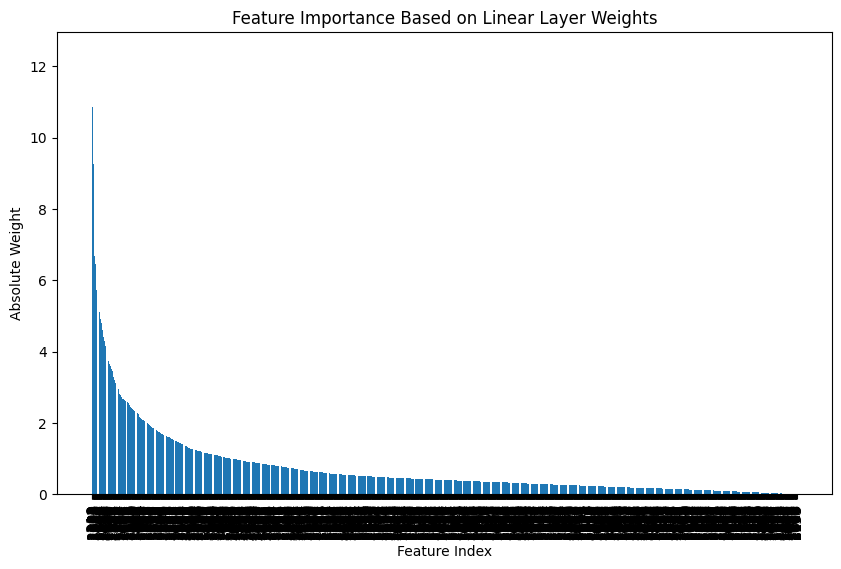

In [19]:
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
weights_np = weights.numpy().flatten()  # Flatten to 1D array

# Calculate the absolute values of the weights
abs_weights = np.abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_np)), abs_weights[top_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
plt.xticks(range(len(weights_np)), top_features, rotation=90)
plt.show()

In [20]:
weights = best_model.l1.weight.data.numpy()
abs_weights = np.abs(weights.flatten())

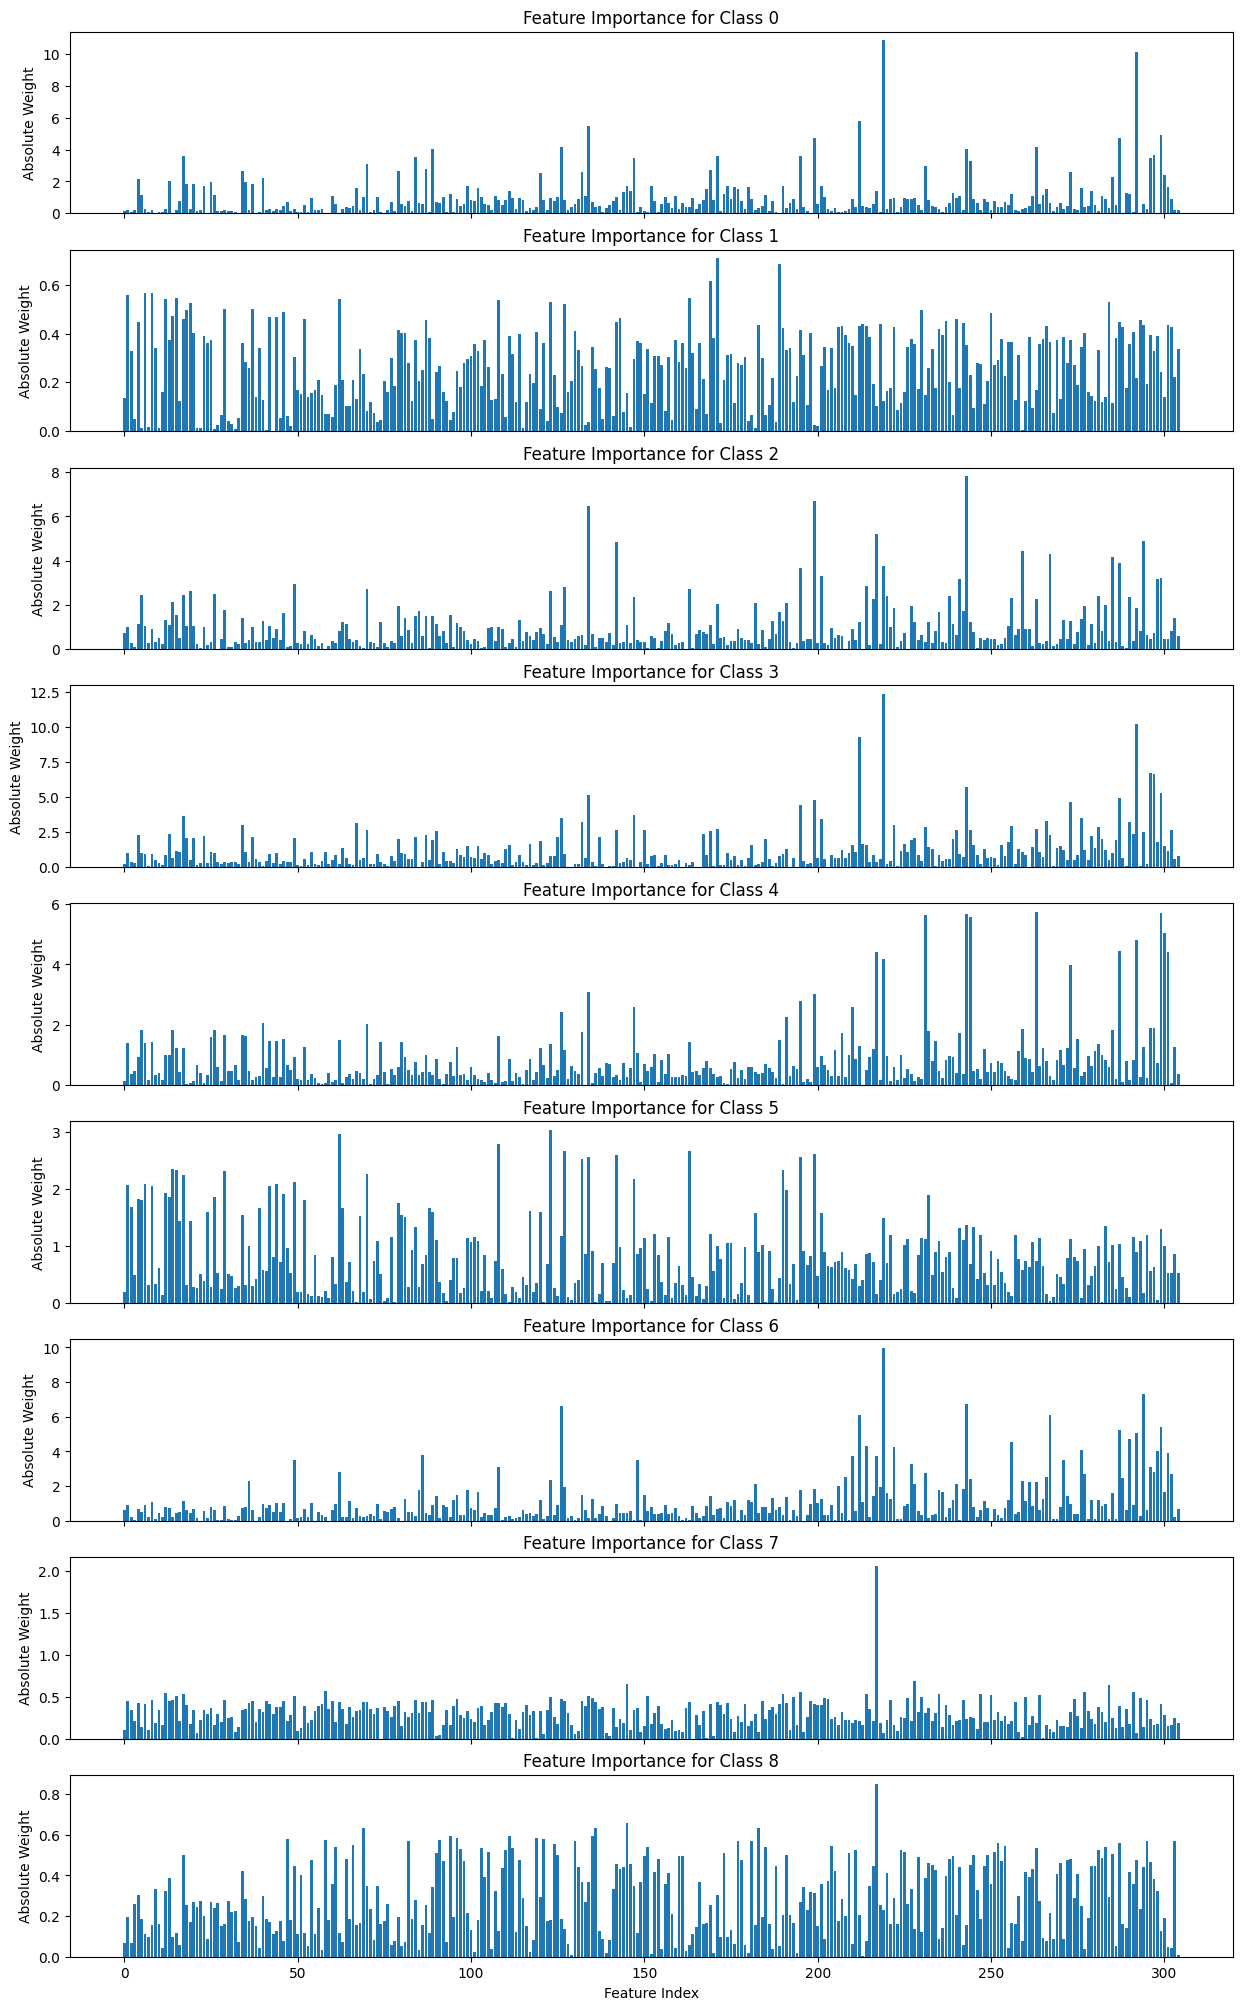

In [21]:
nrows = weights.shape[0]
xrows = weights.shape[1]

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 25), sharex=True)

for i in range(nrows):
    axes[i].bar(range(xrows), abs_weights[i*xrows:(i+1)*xrows])
    axes[i].set_title(f'Feature Importance for Class {i}')
    axes[i].set_ylabel('Absolute Weight')

plt.xlabel('Feature Index')
plt.show()

### Plotting Mean over Classes

In [22]:
from sklearn.preprocessing import minmax_scale

scaled_weights = minmax_scale(weights, axis=0)
weights_mean = np.abs(scaled_weights).mean(axis=0)

In [23]:
sorted_idx = weights_mean.argsort()[::-1]

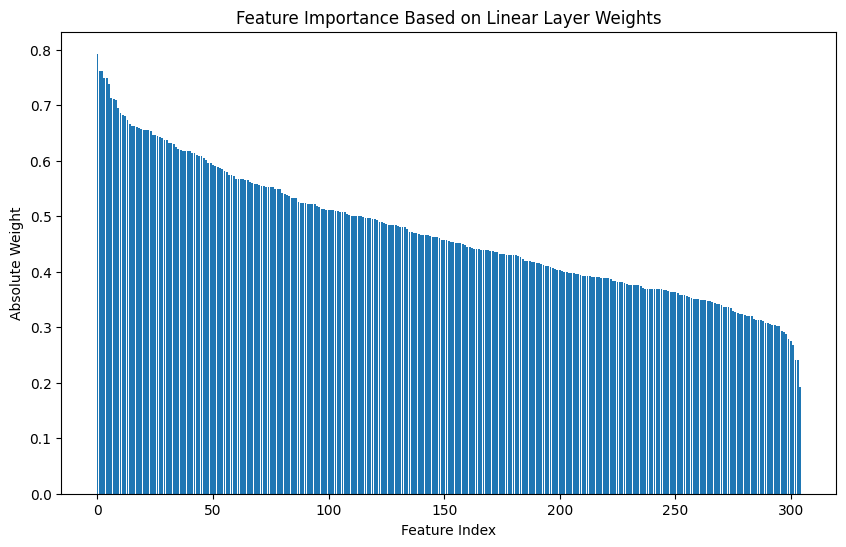

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx])), weights_mean[sorted_idx])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx, sorted_idx, rotation=90)
plt.show()

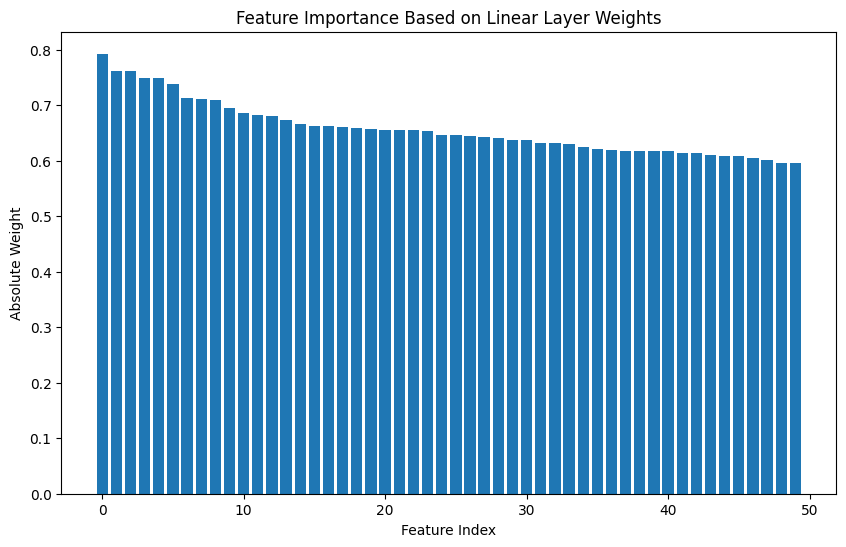

In [25]:
top_k = 50

plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx[:top_k]])), weights_mean[sorted_idx[:top_k]])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Plotting top k per class

In [26]:
topk = 4

In [27]:
topk_indices = weights.argpartition( -topk, axis=1)[:, -topk:]
topk_indices.shape

(9, 4)

In [28]:
topk_indices_sorted = np.take_along_axis(topk_indices, np.argsort(-weights[np.arange(weights.shape[0])[:, None], topk_indices]), axis=1)
topk_indices_sorted.shape

(9, 4)

In [29]:
selected_features = np.array(list(set(topk_indices_sorted.flatten())))
selected_features.shape

(34,)

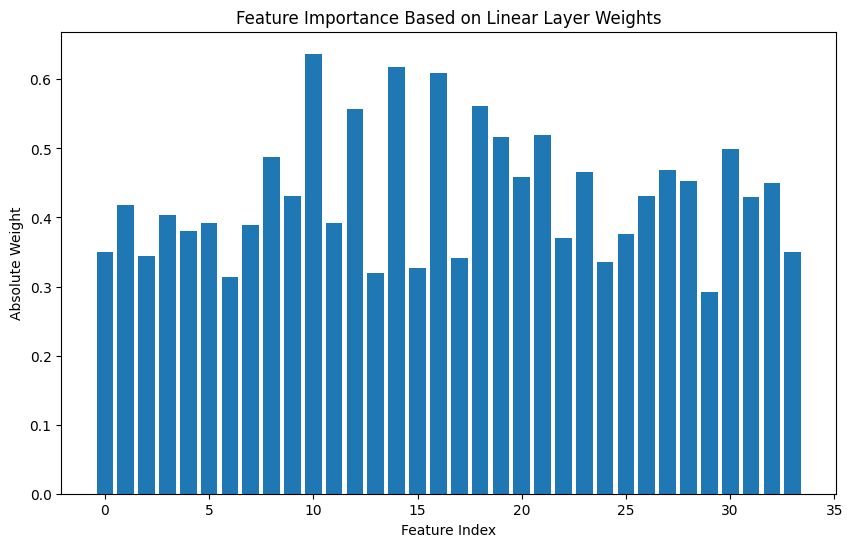

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[selected_features])), weights_mean[selected_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Train again

In [31]:
vectors.iloc[:,selected_features].shape

(16515, 34)

In [32]:
subset = vectors.iloc[:,selected_features]
subset["label"] = df["label"]

/tmp/ipykernel_135900/650136668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["label"] = df["label"]


In [33]:
# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_2)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 315   
------------------------------------------------------------
315       Trainable params
0         Non-trainable params
315       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,  80,   0,  27,   0],
        [  6,   0,   5,   0,   0,  98,   0,   0,   0],
        [  2,   0,   0,   0,   0, 106,   0,  28,   0],
        [  0,   0,   0,   0,   0,  69,   0,  44,   0],
        [ 29,   0,   0,   0,   9,  44,   0,   6,  19],
        [  0,   0,   0,   0,   0,  93,   0,  18,   0],
        [  3,   0,   0,   0,   0,  76,   0,  26,   0],
        [ 78,   0,   0,   0,   0,  23,   0,   0,   0],
        [  3,   0,   0,   0,   0,   0,   0,   0, 108]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,  474,   27,    0,  712,  166,    0,  324,  134],
        [  18, 1647,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1089,  587,    0,    2,  290,    0,  322,    0],
        [   0,  485,   48,    0,  757,  158,    0,  346,  119],
        [  40,  323,    0,    0, 1180,   92,    0,   35,  242],
        [   0, 1253,    2,    0,    0,  365,    0,  281,    0],
        [   3,  722,  454,    0,  160,  195,    0,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 1615,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 1908]])


Metric Validation/Accuracy improved. New best score: 0.595


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,  474,   27,    0,  712,  166,    0,  324,  134],
        [  18, 1647,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1089,  587,    0,    2,  290,    0,  322,    0],
        [   0,  485,   48,    0,  757,  158,    0,  346,  119],
        [  40,  323,    0,    0, 1180,   92,    0,   35,  242],
        [   0, 1253,    2,    0,    0,  365,    0,  281,    0],
        [   3,  722,  454,    0,  160,  195,    0,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 1615,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 1908]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[   0,  474, 1128,    0, 1279,  202,    0,  324,  160],
        [  18, 3472,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1103, 2606,    0,    2,  416,    0,  323,    0],
        [   0,  486, 1279,    4, 1270,  189,    0,  346,  139],
        [  40,  329,    7,    0, 2970,   94,    0,   35,  242],
        [   0, 1287,   20,    0,    0, 2079,    0,  305,    0],
        [   3,  722, 2134,    0,  213,  267,    0,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 3415,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 3708]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[   0,  474, 1128,    0, 1279,  202,    0,  324,  160],
        [  18, 3472,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1103, 2606,    0,    2,  416,    0,  323,    0],
        [   0,  486, 1279,    4, 1270,  189,    0,  346,  139],
        [  40,  329,    7,    0, 2970,   94,    0,   35,  2

Metric Validation/Accuracy improved by 0.069 >= min_delta = 0.0. New best score: 0.664


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[  50,  474, 1803,   28, 2256,  202,    0,  324,  160],
        [  18, 5297,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1107, 4747,    0,   10,  423,    0,  323,    0],
        [   0,  486, 2171,   85, 2097,  189,    0,  346,  139],
        [  40,  329,    9,    0, 4768,   99,    0,   35,  242],
        [   0, 1287,   53,    0,    0, 3831,    0,  310,    0],
        [   3,  722, 3838,    0,  312,  269,    0,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 5215,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 5508]])


Metric Validation/Accuracy improved by 0.024 >= min_delta = 0.0. New best score: 0.689


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[  50,  474, 1803,   28, 2256,  202,    0,  324,  160],
        [  18, 5297,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1107, 4747,    0,   10,  423,    0,  323,    0],
        [   0,  486, 2171,   85, 2097,  189,    0,  346,  139],
        [  40,  329,    9,    0, 4768,   99,    0,   35,  242],
        [   0, 1287,   53,    0,    0, 3831,    0,  310,    0],
        [   3,  722, 3838,    0,  312,  269,    0,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 5215,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 5508]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[ 534,  474, 2453,  464, 2416,  202,    0,  324,  160],
        [  18, 7122,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1107, 6875,    0,   22,  443,    0,  323,    0],
        [   0,  486, 2912,  977, 2264,  189,    0,  346,  139],
        [  40,  329,   14,    0, 6563,  104,    0,   35,  242],
        [   0, 1287,   72,    0,    0, 5597,    0,  315,    0],
        [   3,  722, 5581,   43,  329,  271,    0,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 7015,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 7308]])


Metric Validation/Accuracy improved by 0.120 >= min_delta = 0.0. New best score: 0.808


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[ 534,  474, 2453,  464, 2416,  202,    0,  324,  160],
        [  18, 7122,   26,    0,    0,  241,    0,    2,    0],
        [   6, 1107, 6875,    0,   22,  443,    0,  323,    0],
        [   0,  486, 2912,  977, 2264,  189,    0,  346,  139],
        [  40,  329,   14,    0, 6563,  104,    0,   35,  242],
        [   0, 1287,   72,    0,    0, 5597,    0,  315,    0],
        [   3,  722, 5581,   43,  329,  271,    0,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 7015,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 7308]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[1767,  474, 2504,  894, 2432,  202,    0,  324,  160],
        [  18, 8942,   26,    0,    0,  246,    0,    2,    0],
        [   6, 1107, 8997,    0,   34,  469,    0,  323,    0],
        [   3,  486, 3087, 2514, 2330,  189,   19,  346,  139],
        [  40,  329,   19,    0, 8358,  109,    0,   35,  242],
        [   0, 1287,   79,    0,    0, 7375,    0,  320,    0],
        [   3,  722, 7229,  172,  345,  276,    7,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 8815,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 9108]])


Metric Validation/Accuracy improved by 0.032 >= min_delta = 0.0. New best score: 0.840


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[1767,  474, 2504,  894, 2432,  202,    0,  324,  160],
        [  18, 8942,   26,    0,    0,  246,    0,    2,    0],
        [   6, 1107, 8997,    0,   34,  469,    0,  323,    0],
        [   3,  486, 3087, 2514, 2330,  189,   19,  346,  139],
        [  40,  329,   19,    0, 8358,  109,    0,   35,  242],
        [   0, 1287,   79,    0,    0, 7375,    0,  320,    0],
        [   3,  722, 7229,  172,  345,  276,    7,  366,   10],
        [ 143,  103,    0,    0,    0,   40,    0, 8815,    0],
        [   3,    0,    0,    0,    0,    0,    0,    0, 9108]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 2665,   474,  2529,  1696,  2437,   202,     0,   324,   160],
        [   18, 10761,    26,     0,     0,   252,     0,     2,     0],
        [    6,  1107, 11102,     0,    46,   512,     0,   323,     0],
        [    8,   486,  3161,  4210,  2355,   189,    19,   346,   139],
        [   40,   329,    22,     0, 10155,   114,     0,    35,   242],
        [    0,  1287,    79,     0,     0,  9160,     0,   325,     0],
        [    3,   722,  8809,   369,   364,   285,     7,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 10615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 10908]])
Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 2665,   474,  2529,  1696,  2437,   202,     0,   324,   160],
        [   18, 10761,    26,     0,     0,   252,     0,     2,     0],
        [    6,  1107, 11102,     0,    46,   512,     0,   323,     0],
        [    8,

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.842


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 4210,   474,  2536,  1874,  2437,   202,     0,   324,   160],
        [   18, 12576,    26,     0,     0,   262,     0,     2,     0],
        [    6,  1107, 13220,     0,    58,   542,     0,   323,     0],
        [   54,   486,  3216,  5888,  2373,   189,    22,   346,   139],
        [   40,   329,    27,     0, 11950,   119,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 10947,     0,   328,     0],
        [   11,   722, 10378,   561,   378,   290,    24,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 12415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 12708]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 4210,   474,  2536,  1874,  2437,   202,     0,   324,   160],
        [   18, 12576,    26,     0,     0,   262,     0,     2,     0],
        [    6,  1107, 13220,     0,    58,   542,     0,   323,     0],
        [   54,

Metric Validation/Accuracy improved by 0.028 >= min_delta = 0.0. New best score: 0.870


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 5793,   474,  2545,  2012,  2437,   202,     0,   324,   160],
        [   18, 14391,    26,     0,     0,   272,     0,     2,     0],
        [    6,  1107, 15324,     0,    70,   586,     0,   323,     0],
        [   94,   486,  3267,  7589,  2381,   189,    22,   346,   139],
        [   40,   329,    31,     0, 13746,   124,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 12737,     0,   328,     0],
        [   21,   722, 11916,   783,   391,   300,    36,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 14215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 14508]])


Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.874


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 5793,   474,  2545,  2012,  2437,   202,     0,   324,   160],
        [   18, 14391,    26,     0,     0,   272,     0,     2,     0],
        [    6,  1107, 15324,     0,    70,   586,     0,   323,     0],
        [   94,   486,  3267,  7589,  2381,   189,    22,   346,   139],
        [   40,   329,    31,     0, 13746,   124,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 12737,     0,   328,     0],
        [   21,   722, 11916,   783,   391,   300,    36,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 14215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 14508]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[ 7422,   474,  2550,  2108,  2437,   202,     0,   324,   160],
        [   18, 16206,    26,     0,     0,   282,     0,     2,     0],
        [    6,  1107, 17427,     0,    82,   631,     0,   323,     0],
        [  142,   486,  3301,  9294,  2392,   189,    24,   346,   139],
        [   40,   329,    31,     1, 15545,   129,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 14527,     0,   328,     0],
        [   36,   722, 13327,  1053,   414,   311,   111,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 16015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 16308]])
Epoch end: Train, epoch number: 8


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.875


TrainEpoch/CM
 tensor([[ 7422,   474,  2550,  2108,  2437,   202,     0,   324,   160],
        [   18, 16206,    26,     0,     0,   282,     0,     2,     0],
        [    6,  1107, 17427,     0,    82,   631,     0,   323,     0],
        [  142,   486,  3301,  9294,  2392,   189,    24,   346,   139],
        [   40,   329,    31,     1, 15545,   129,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 14527,     0,   328,     0],
        [   36,   722, 13327,  1053,   414,   311,   111,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 16015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 16308]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[ 8912,   474,  2555,  2343,  2437,   202,     0,   324,   160],
        [   18, 18021,    26,     0,     0,   292,     0,     2,     0],
        [    6,  1107, 19518,     9,    94,   679,     0,   323,     0],
        [  164,   486,  3315, 11056,  2394,   189,    24,   346,   139],
        [   40,   329,    34,     6, 17337,   134,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 16317,     0,   328,     0],
        [   46,   722, 14720,  1377,   420,   321,   173,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 17815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 18108]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.879


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[ 8912,   474,  2555,  2343,  2437,   202,     0,   324,   160],
        [   18, 18021,    26,     0,     0,   292,     0,     2,     0],
        [    6,  1107, 19518,     9,    94,   679,     0,   323,     0],
        [  164,   486,  3315, 11056,  2394,   189,    24,   346,   139],
        [   40,   329,    34,     6, 17337,   134,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 16317,     0,   328,     0],
        [   46,   722, 14720,  1377,   420,   321,   173,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 17815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 18108]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[10586,   474,  2560,  2394,  2437,   202,     0,   324,   160],
        [   18, 19836,    26,     0,     0,   302,     0,     2,     0],
        [    6,  1107, 21616,    11,   106,   727,     0,   323,     0],
        [  249,   486,  3339, 12737,  2399,   189,    29,   346,   139],
        [   40,   329,    40,    11, 19126,   139,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 18107,     0,   328,     0],
        [   86,   722, 16097,  1618,   426,   331,   304,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 19615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 19908]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.879


Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[10586,   474,  2560,  2394,  2437,   202,     0,   324,   160],
        [   18, 19836,    26,     0,     0,   302,     0,     2,     0],
        [    6,  1107, 21616,    11,   106,   727,     0,   323,     0],
        [  249,   486,  3339, 12737,  2399,   189,    29,   346,   139],
        [   40,   329,    40,    11, 19126,   139,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 18107,     0,   328,     0],
        [   86,   722, 16097,  1618,   426,   331,   304,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 19615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 19908]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[12159,   474,  2562,  2549,  2437,   202,     0,   324,   160],
        [   18, 21651,    26,     0,     0,   312,     0,     2,     0],
        [    6,  1107, 23696,    23,   118,   775,     8,   323,     0],
        [  272,   486,  3349, 14495,  2399,   189,    38,   346,   139],
        [   40,   329,    45,    16, 20916,   144,     0,    35,   242],
        [    0,  1287,    79,     0,     0, 19897,     0,   328,     0],
        [  100,   722, 17377,  1920,   431,   341,   498,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 21415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 21708]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[12159,   474,  2562,  2549,  2437,   202,     0,   324,   160],
        [   18, 21651,    26,     0,     0,   312,     0,     2,     0],
        [    6,  1107, 23696,    23,   118,   775,     8,   323,     0],
        [  27

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[13821,   474,  2566,  2613,  2437,   202,     0,   324,   160],
        [   18, 23466,    26,     0,     0,   322,     0,     2,     0],
        [    6,  1107, 25799,    31,   130,   807,    13,   323,     0],
        [  345,   486,  3365, 16204,  2399,   189,    40,   346,   139],
        [   40,   329,    53,    21, 22703,   149,     0,    35,   242],
        [    0,  1287,    82,     0,     0, 21684,     0,   328,     0],
        [  130,   722, 18737,  2200,   436,   351,   618,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 23215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 23508]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[13821,   474,  2566,  2613,  2437,   202,     0,   324,   160],
        [   18, 23466,    26,     0,     0,   322,     0,     2,     0],
        [    6,  1107, 25799,    31,   130,   807,    13,   323,     0],
        [  34

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[15492,   474,  2568,  2670,  2437,   202,     0,   324,   160],
        [   18, 25281,    26,     0,     0,   332,     0,     2,     0],
        [    6,  1107, 27867,    43,   142,   854,    34,   323,     0],
        [  422,   486,  3376, 17911,  2399,   189,    45,   346,   139],
        [   40,   329,    60,    26, 24491,   154,     0,    35,   242],
        [    0,  1287,    82,     0,     0, 23474,     0,   328,     0],
        [  167,   722, 19985,  2482,   441,   361,   841,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 25015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 25308]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[15492,   474,  2568,  2670,  2437,   202,     0,   324,   160],
        [   18, 25281,    26,     0,     0,   332,     0,     2,     0],
        [    6,  1107, 27867,    43,   142,   854,    34,   323,     0],
        [  42

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.886


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[17179,   474,  2569,  2712,  2437,   202,     0,   324,   160],
        [   18, 27096,    26,     0,     0,   342,     0,     2,     0],
        [    6,  1107, 29941,    55,   154,   897,    53,   323,     0],
        [  511,   486,  3391, 19602,  2399,   189,    50,   346,   139],
        [   40,   329,    70,    31, 26276,   159,     0,    35,   242],
        [    0,  1287,    83,     0,     0, 25263,     0,   328,     0],
        [  207,   722, 21237,  2735,   446,   371,  1086,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 26815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 27108]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[17179,   474,  2569,  2712,  2437,   202,     0,   324,   160],
        [   18, 27096,    26,     0,     0,   342,     0,     2,     0],
        [    6,  1107, 29941,    55,   154,   897,    53,   323,     0],
        [  51

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[18867,   474,  2569,  2754,  2437,   202,     0,   324,   160],
        [   18, 28911,    26,     0,     0,   352,     0,     2,     0],
        [    6,  1107, 32006,    67,   166,   942,    79,   323,     0],
        [  591,   486,  3401, 21306,  2399,   189,    56,   346,   139],
        [   40,   329,    75,    36, 28066,   164,     0,    35,   242],
        [    0,  1287,    83,     0,     0, 27053,     0,   328,     0],
        [  251,   722, 22392,  3001,   451,   381,  1411,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 28615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 28908]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[18867,   474,  2569,  2754,  2437,   202,     0,   324,   160],
        [   18, 28911,    26,     0,     0,   352,     0,     2,     0],
        [    6,  1107, 32006,    67,   166,   942,    79,   323,     0],
        [  59

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[20543,   474,  2569,  2808,  2437,   202,     0,   324,   160],
        [   18, 30726,    26,     0,     0,   362,     0,     2,     0],
        [    6,  1107, 34077,    79,   178,   983,   103,   323,     0],
        [  658,   486,  3412, 23023,  2399,   189,    61,   346,   139],
        [   40,   329,    83,    41, 29853,   169,     0,    35,   242],
        [    0,  1287,    84,     0,     0, 28842,     0,   328,     0],
        [  278,   722, 23598,  3276,   456,   391,  1693,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 30415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 30708]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[20543,   474,  2569,  2808,  2437,   202,     0,   324,   160],
        [   18, 30726,    26,     0,     0,   362,     0,     2,     0],
        [    6,  1107, 34077,    79,   178,   983,   103,   323,     0],
        [  65

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[22233,   474,  2569,  2848,  2437,   202,     0,   324,   160],
        [   18, 32541,    26,     0,     0,   372,     0,     2,     0],
        [    6,  1107, 36144,    91,   190,  1024,   131,   323,     0],
        [  740,   486,  3424, 24723,  2399,   189,    67,   346,   139],
        [   40,   329,    92,    46, 31639,   174,     0,    35,   242],
        [    0,  1287,    86,     0,     0, 30630,     0,   328,     0],
        [  316,   722, 24743,  3535,   461,   401,  2041,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 32215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 32508]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[22233,   474,  2569,  2848,  2437,   202,     0,   324,   160],
        [   18, 32541,    26,     0,     0,   372,     0,     2,     0],
        [    6,  1107, 36144,    91,   190,  1024,   131,   323,     0],
        [  74

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[23923,   474,  2569,  2888,  2437,   202,     0,   324,   160],
        [   18, 34356,    26,     0,     0,   382,     0,     2,     0],
        [    6,  1107, 38209,   103,   202,  1063,   163,   323,     0],
        [  822,   486,  3436, 26420,  2399,   189,    76,   346,   139],
        [   40,   329,   100,    51, 33426,   179,     0,    35,   242],
        [    0,  1287,    88,     0,     0, 32418,     0,   328,     0],
        [  356,   722, 25809,  3789,   466,   408,  2474,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 34015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 34308]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.899


Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[23923,   474,  2569,  2888,  2437,   202,     0,   324,   160],
        [   18, 34356,    26,     0,     0,   382,     0,     2,     0],
        [    6,  1107, 38209,   103,   202,  1063,   163,   323,     0],
        [  822,   486,  3436, 26420,  2399,   189,    76,   346,   139],
        [   40,   329,   100,    51, 33426,   179,     0,    35,   242],
        [    0,  1287,    88,     0,     0, 32418,     0,   328,     0],
        [  356,   722, 25809,  3789,   466,   408,  2474,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 34015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 34308]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[25611,   474,  2569,  2930,  2437,   202,     0,   324,   160],
        [   18, 36171,    26,     0,     0,   392,     0,     2,     0],
        [    6,  1107, 40275,   115,   214,  1104,   192,   323,     0],
        [  907,   486,  3445, 28119,  2399,   189,    83,   346,   139],
        [   40,   329,   108,    56, 35213,   184,     0,    35,   242],
        [    0,  1287,    88,     0,     0, 34208,     0,   328,     0],
        [  388,   722, 26899,  4057,   471,   418,  2874,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 35815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 36108]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[25611,   474,  2569,  2930,  2437,   202,     0,   324,   160],
        [   18, 36171,    26,     0,     0,   392,     0,     2,     0],
        [    6,  1107, 40275,   115,   214,  1104,   192,   323,     0],
        [  90

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[27298,   474,  2569,  2973,  2437,   202,     0,   324,   160],
        [   18, 37986,    26,     0,     0,   402,     0,     2,     0],
        [    6,  1107, 42335,   127,   226,  1144,   228,   323,     0],
        [  985,   486,  3453, 29825,  2399,   189,    91,   346,   139],
        [   40,   329,   119,    64, 36994,   189,     0,    35,   242],
        [    0,  1287,    92,     0,     0, 35994,     0,   328,     0],
        [  418,   722, 27966,  4321,   476,   425,  3306,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 37615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 37908]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[27298,   474,  2569,  2973,  2437,   202,     0,   324,   160],
        [   18, 37986,    26,     0,     0,   402,     0,     2,     0],
        [    6,  1107, 42335,   127,   226,  1144,   228,   323,     0],
        [  98

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.902


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[28994,   474,  2569,  3007,  2437,   202,     0,   324,   160],
        [   18, 39801,    26,     0,     0,   412,     0,     2,     0],
        [    6,  1107, 44366,   139,   238,  1184,   293,   323,     0],
        [ 1074,   486,  3458, 31519,  2399,   189,   103,   346,   139],
        [   40,   329,   126,    69, 38782,   194,     0,    35,   242],
        [    0,  1287,    92,     0,     0, 37784,     0,   328,     0],
        [  463,   722, 28876,  4550,   481,   430,  3917,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 39415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 39708]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.905


Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[28994,   474,  2569,  3007,  2437,   202,     0,   324,   160],
        [   18, 39801,    26,     0,     0,   412,     0,     2,     0],
        [    6,  1107, 44366,   139,   238,  1184,   293,   323,     0],
        [ 1074,   486,  3458, 31519,  2399,   189,   103,   346,   139],
        [   40,   329,   126,    69, 38782,   194,     0,    35,   242],
        [    0,  1287,    92,     0,     0, 37784,     0,   328,     0],
        [  463,   722, 28876,  4550,   481,   430,  3917,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 39415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 39708]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[30685,   474,  2569,  3046,  2437,   202,     0,   324,   160],
        [   18, 41616,    26,     0,     0,   422,     0,     2,     0],
        [    6,  1107, 46420,   151,   250,  1220,   339,   323,     0],
        [ 1147,   486,  3463, 33229,  2399,   189,   115,   346,   139],
        [   40,   329,   134,    76, 40567,   199,     0,    35,   242],
        [    0,  1287,    97,     0,     0, 39569,     0,   328,     0],
        [  501,   722, 29845,  4801,   486,   435,  4454,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 41215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 41508]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[30685,   474,  2569,  3046,  2437,   202,     0,   324,   160],
        [   18, 41616,    26,     0,     0,   422,     0,     2,     0],
        [    6,  1107, 46420,   151,   250,  1220,   339,   323,     0],
        [ 114

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[32380,   474,  2569,  3081,  2437,   202,     0,   324,   160],
        [   18, 43431,    26,     0,     0,   432,     0,     2,     0],
        [    6,  1107, 48478,   163,   262,  1255,   382,   323,     0],
        [ 1227,   486,  3468, 34929,  2399,   189,   130,   346,   139],
        [   40,   329,   143,    85, 42349,   204,     0,    35,   242],
        [    0,  1287,   102,     0,     0, 41354,     0,   328,     0],
        [  540,   722, 30792,  5038,   490,   440,  5027,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 43015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 43308]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[32380,   474,  2569,  3081,  2437,   202,     0,   324,   160],
        [   18, 43431,    26,     0,     0,   432,     0,     2,     0],
        [    6,  1107, 48478,   163,   262,  1255,   382,   323,     0],
        [ 122

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[34076,   474,  2569,  3115,  2437,   202,     0,   324,   160],
        [   18, 45246,    26,     0,     0,   442,     0,     2,     0],
        [    6,  1107, 50530,   175,   274,  1291,   430,   323,     0],
        [ 1316,   486,  3471, 36626,  2399,   189,   141,   346,   139],
        [   40,   329,   151,    93, 44133,   209,     0,    35,   242],
        [    0,  1287,   106,     0,     0, 43140,     0,   328,     0],
        [  585,   722, 31697,  5278,   490,   445,  5637,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 44815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 45108]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[34076,   474,  2569,  3115,  2437,   202,     0,   324,   160],
        [   18, 45246,    26,     0,     0,   442,     0,     2,     0],
        [    6,  1107, 50530,   175,   274,  1291,   430,   323,     0],
        [ 131

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[35768,   474,  2569,  3153,  2437,   202,     0,   324,   160],
        [   18, 47061,    26,     0,     0,   452,     0,     2,     0],
        [    6,  1107, 52582,   187,   280,  1327,   484,   323,     0],
        [ 1385,   486,  3471, 38341,  2399,   189,   157,   346,   139],
        [   40,   329,   159,    99, 45919,   214,     0,    35,   242],
        [    0,  1287,   109,     0,     0, 44927,     0,   328,     0],
        [  618,   722, 32580,  5516,   490,   450,  6283,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 46615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 46908]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[35768,   474,  2569,  3153,  2437,   202,     0,   324,   160],
        [   18, 47061,    26,     0,     0,   452,     0,     2,     0],
        [    6,  1107, 52582,   187,   280,  1327,   484,   323,     0],
        [ 138

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[37468,   474,  2569,  3183,  2437,   202,     0,   324,   160],
        [   18, 48876,    26,     0,     0,   462,     0,     2,     0],
        [    6,  1107, 54619,   199,   288,  1365,   549,   323,     0],
        [ 1496,   486,  3471, 40015,  2399,   189,   172,   346,   139],
        [   40,   329,   170,   104, 47703,   219,     0,    35,   242],
        [    0,  1287,   109,     0,     0, 46717,     0,   328,     0],
        [  666,   722, 33434,  5719,   490,   455,  6978,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 48415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 48708]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.909


Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[37468,   474,  2569,  3183,  2437,   202,     0,   324,   160],
        [   18, 48876,    26,     0,     0,   462,     0,     2,     0],
        [    6,  1107, 54619,   199,   288,  1365,   549,   323,     0],
        [ 1496,   486,  3471, 40015,  2399,   189,   172,   346,   139],
        [   40,   329,   170,   104, 47703,   219,     0,    35,   242],
        [    0,  1287,   109,     0,     0, 46717,     0,   328,     0],
        [  666,   722, 33434,  5719,   490,   455,  6978,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 48415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 48708]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[39163,   474,  2569,  3218,  2437,   202,     0,   324,   160],
        [   18, 50691,    26,     0,     0,   472,     0,     2,     0],
        [    6,  1107, 56674,   211,   288,  1396,   611,   323,     0],
        [ 1566,   486,  3474, 41720,  2399,   189,   194,   346,   139],
        [   40,   329,   184,   114, 49479,   224,     0,    35,   242],
        [    0,  1287,   114,     0,     0, 48502,     0,   328,     0],
        [  701,   722, 34308,  5926,   490,   460,  7662,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 50215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 50508]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[39163,   474,  2569,  3218,  2437,   202,     0,   324,   160],
        [   18, 50691,    26,     0,     0,   472,     0,     2,     0],
        [    6,  1107, 56674,   211,   288,  1396,   611,   323,     0],
        [ 156

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.910


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[40863,   474,  2569,  3248,  2437,   202,     0,   324,   160],
        [   18, 52506,    26,     0,     0,   482,     0,     2,     0],
        [    6,  1107, 58733,   223,   288,  1432,   664,   323,     0],
        [ 1650,   486,  3474, 43419,  2399,   189,   211,   346,   139],
        [   40,   329,   193,   122, 51262,   229,     0,    35,   242],
        [    0,  1287,   117,     0,     0, 50289,     0,   328,     0],
        [  748,   722, 35216,  6144,   490,   465,  8289,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 52015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 52308]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[40863,   474,  2569,  3248,  2437,   202,     0,   324,   160],
        [   18, 52506,    26,     0,     0,   482,     0,     2,     0],
        [    6,  1107, 58733,   223,   288,  1432,   664,   323,     0],
        [ 165

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[42559,   474,  2569,  3282,  2437,   202,     0,   324,   160],
        [   18, 54324,    26,     0,     0,   489,     0,     2,     0],
        [    6,  1107, 60781,   235,   288,  1462,   734,   323,     0],
        [ 1721,   486,  3474, 45121,  2399,   189,   238,   346,   139],
        [   40,   329,   198,   129, 53050,   234,     0,    35,   242],
        [    0,  1287,   120,     0,     0, 52076,     0,   328,     0],
        [  773,   722, 35993,  6347,   490,   470,  9084,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 53815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 54108]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.914


Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[42559,   474,  2569,  3282,  2437,   202,     0,   324,   160],
        [   18, 54324,    26,     0,     0,   489,     0,     2,     0],
        [    6,  1107, 60781,   235,   288,  1462,   734,   323,     0],
        [ 1721,   486,  3474, 45121,  2399,   189,   238,   346,   139],
        [   40,   329,   198,   129, 53050,   234,     0,    35,   242],
        [    0,  1287,   120,     0,     0, 52076,     0,   328,     0],
        [  773,   722, 35993,  6347,   490,   470,  9084,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 53815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 54108]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[44255,   474,  2569,  3316,  2437,   202,     0,   324,   160],
        [   18, 56141,    26,     0,     0,   497,     0,     2,     0],
        [    6,  1107, 62814,   247,   288,  1494,   817,   323,     0],
        [ 1797,   486,  3474, 46824,  2399,   189,   259,   346,   139],
        [   40,   329,   208,   141, 54828,   239,     0,    35,   242],
        [    0,  1287,   120,     0,     0, 53866,     0,   328,     0],
        [  808,   722, 36804,  6564,   490,   475,  9821,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 55615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 55908]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[44255,   474,  2569,  3316,  2437,   202,     0,   324,   160],
        [   18, 56141,    26,     0,     0,   497,     0,     2,     0],
        [    6,  1107, 62814,   247,   288,  1494,   817,   323,     0],
        [ 179

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[45953,   474,  2569,  3348,  2437,   202,     0,   324,   160],
        [   18, 57965,    26,     0,     0,   498,     0,     2,     0],
        [    6,  1107, 64878,   259,   288,  1523,   872,   323,     0],
        [ 1876,   486,  3476, 48523,  2399,   189,   279,   346,   139],
        [   40,   329,   217,   147, 56613,   244,     0,    35,   242],
        [    0,  1287,   125,     0,     0, 55651,     0,   328,     0],
        [  850,   722, 37671,  6779,   490,   480, 10497,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 57415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 57708]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[45953,   474,  2569,  3348,  2437,   202,     0,   324,   160],
        [   18, 57965,    26,     0,     0,   498,     0,     2,     0],
        [    6,  1107, 64878,   259,   288,  1523,   872,   323,     0],
        [ 187

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.916


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[47651,   474,  2569,  3380,  2437,   202,     0,   324,   160],
        [   18, 59789,    26,     0,     0,   499,     0,     2,     0],
        [    6,  1107, 66912,   271,   288,  1553,   956,   323,     0],
        [ 1943,   486,  3476, 50229,  2399,   189,   306,   346,   139],
        [   40,   329,   225,   157, 58395,   249,     0,    35,   242],
        [    0,  1287,   127,     0,     0, 57439,     0,   328,     0],
        [  875,   722, 38425,  6977,   490,   485, 11320,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 59215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 59508]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[47651,   474,  2569,  3380,  2437,   202,     0,   324,   160],
        [   18, 59789,    26,     0,     0,   499,     0,     2,     0],
        [    6,  1107, 66912,   271,   288,  1553,   956,   323,     0],
        [ 194

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[49351,   474,  2569,  3410,  2437,   202,     0,   324,   160],
        [   18, 61610,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 68945,   283,   288,  1585,  1039,   323,     0],
        [ 2017,   486,  3476, 51935,  2399,   189,   326,   346,   139],
        [   40,   329,   230,   167, 60180,   254,     0,    35,   242],
        [    0,  1287,   127,     0,     0, 59229,     0,   328,     0],
        [  910,   722, 39228,  7180,   490,   490, 12079,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 61015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 61308]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[49351,   474,  2569,  3410,  2437,   202,     0,   324,   160],
        [   18, 61610,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 68945,   283,   288,  1585,  1039,   323,     0],
        [ 201

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[51050,   474,  2569,  3441,  2437,   202,     0,   324,   160],
        [   18, 63435,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 70994,   295,   288,  1615,  1108,   323,     0],
        [ 2091,   486,  3476, 53634,  2399,   189,   353,   346,   139],
        [   40,   329,   243,   176, 61958,   259,     0,    35,   242],
        [    0,  1287,   129,     0,     0, 61017,     0,   328,     0],
        [  946,   722, 39989,  7375,   490,   495, 12887,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 62815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 63108]])


Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.925


Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[51050,   474,  2569,  3441,  2437,   202,     0,   324,   160],
        [   18, 63435,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 70994,   295,   288,  1615,  1108,   323,     0],
        [ 2091,   486,  3476, 53634,  2399,   189,   353,   346,   139],
        [   40,   329,   243,   176, 61958,   259,     0,    35,   242],
        [    0,  1287,   129,     0,     0, 61017,     0,   328,     0],
        [  946,   722, 39989,  7375,   490,   495, 12887,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 62815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 63108]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[52748,   474,  2569,  3473,  2437,   202,     0,   324,   160],
        [   18, 65260,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 73026,   307,   288,  1644,  1195,   323,     0],
        [ 2158,   486,  3476, 55339,  2399,   189,   381,   346,   139],
        [   40,   329,   251,   186, 63740,   264,     0,    35,   242],
        [    0,  1287,   131,     0,     0, 62805,     0,   328,     0],
        [  972,   722, 40669,  7572,   490,   500, 13784,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 64615,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 64908]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[52748,   474,  2569,  3473,  2437,   202,     0,   324,   160],
        [   18, 65260,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 73026,   307,   288,  1644,  1195,   323,     0],
        [ 215

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[54444,   474,  2569,  3507,  2437,   202,     0,   324,   160],
        [   18, 67085,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 75077,   319,   288,  1672,  1264,   323,     0],
        [ 2222,   486,  3476, 57049,  2399,   189,   407,   346,   139],
        [   40,   329,   258,   196, 65523,   269,     0,    35,   242],
        [    0,  1287,   133,     0,     0, 64593,     0,   328,     0],
        [  998,   722, 41439,  7776,   490,   505, 14584,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 66415,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 66708]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[54444,   474,  2569,  3507,  2437,   202,     0,   324,   160],
        [   18, 67085,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 75077,   319,   288,  1672,  1264,   323,     0],
        [ 222

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[56143,   474,  2569,  3538,  2437,   202,     0,   324,   160],
        [   18, 68910,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 77107,   331,   288,  1700,  1354,   323,     0],
        [ 2287,   486,  3476, 58749,  2399,   189,   442,   346,   139],
        [   40,   329,   267,   206, 67304,   274,     0,    35,   242],
        [    0,  1287,   133,     0,     0, 66383,     0,   328,     0],
        [ 1027,   722, 42057,  7962,   490,   510, 15551,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 68215,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 68508]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[56143,   474,  2569,  3538,  2437,   202,     0,   324,   160],
        [   18, 68910,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 77107,   331,   288,  1700,  1354,   323,     0],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[57843,   474,  2569,  3568,  2437,   202,     0,   324,   160],
        [   18, 70735,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 79146,   343,   288,  1725,  1438,   323,     0],
        [ 2352,   486,  3476, 60449,  2399,   189,   477,   346,   139],
        [   40,   329,   274,   215, 69088,   279,     0,    35,   242],
        [    0,  1287,   133,     0,     0, 68173,     0,   328,     0],
        [ 1052,   722, 42695,  8149,   490,   515, 16501,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 70015,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 70308]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[57843,   474,  2569,  3568,  2437,   202,     0,   324,   160],
        [   18, 70735,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 79146,   343,   288,  1725,  1438,   323,     0],
        [ 235

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[59541,   474,  2569,  3600,  2437,   202,     0,   324,   160],
        [   18, 72560,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 81198,   355,   288,  1749,  1510,   323,     0],
        [ 2417,   486,  3476, 62153,  2399,   189,   508,   346,   139],
        [   40,   329,   282,   225, 70870,   284,     0,    35,   242],
        [    0,  1287,   133,     0,     0, 69963,     0,   328,     0],
        [ 1079,   722, 43387,  8342,   490,   520, 17389,   366,    10],
        [  143,   103,     0,     0,     0,    40,     0, 71815,     0],
        [    3,     0,     0,     0,     0,     0,     0,     0, 72108]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[59541,   474,  2569,  3600,  2437,   202,     0,   324,   160],
        [   18, 72560,    26,     0,     0,   503,     0,     2,     0],
        [    6,  1107, 81198,   355,   288,  1749,  1510,   323,     0],
        [ 241

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.925. Signaling Trainer to stop.


In [35]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

/home/<User>/repos/csg_is/training/official_logs/single-layer_30_from_weights_40s/version_0/checkpoints/epoch=34-step=945.ckpt
tensor(0.9254, device='cuda:0')


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[367,   0,   0,   9,   0,   0,   0,   0,   0],
        [  0, 317,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 407,   2,   0,   8,  26,   0,   0],
        [ 13,   0,   0, 350,   0,   0,   9,   0,   0],
        [  0,   0,   2,   2, 336,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 367,   0,   0,   0],
        [ 10,   0, 131,  41,   0,   0, 184,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 342,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 380]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9254440665245056
      Test/F1Score          0.9216607213020325
        Test/Loss           0.4790020287036896
     Test/Precision         0.

[{'Test/Loss': 0.4790020287036896,
  'Test/Accuracy': 0.9254440665245056,
  'Test/Precision': 0.9307817816734314,
  'Test/Recall': 0.9254440665245056,
  'Test/F1Score': 0.9216607213020325,
  'TestEpoch/Accuracy': 0.9251808524131775,
  'TestEpoch/Precision': 0.9311016798019409,
  'TestEpoch/Recall': 0.9251808524131775,
  'TestEpoch/F1Score': 0.9223027229309082}]

In [36]:
sys.path.append(str(repo_base_path  / "training"))

In [37]:
# tensorboard = pl_loggers.TensorBoardLogger('./')

from mlp import MalwaresModelMLP

# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_3)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelMLP(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 1.1 K 
6 | l2            | Linear                    | 930   
7 | l3            | Linear                    | 279   
------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0, 107],
        [  0,   0,   0,   0,   0,   0,   0,   0, 109],
        [  0,   0,   0,   0,   0,   0,   0,   0, 136],
        [  0,   0,   0,   0,   0,   0,   0,   0, 113],
        [  0,   0,   0,   0,   0,   0,   0,   0, 107],
        [  0,   0,   0,   0,   0,   0,   0,   0, 111],
        [  0,   0,   0,   0,   0,   0,   0,   0, 105],
        [  0,   0,   0,   0,   0,   0,   0,   0, 101],
        [  0,   0,   0,   0,   0,   0,   0,   0, 111]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,  436, 1073,    0,    0,    2,    5,    0,  321],
        [   0, 1696,    0,    0,    0,    1,    0,    0,  237],
        [   0,  580, 1131,    0,    0,  131,   42,   17,  395],
        [   0,  419, 1142,    0,    0,    1,    5,    0,  346],
        [   0,  453,  999,    0,   57,    4,   31,    4,  364],
        [   0,  495,   57,    0,    0,  714,    0,  315,  320],
        [   0,  496, 1047,    0,    0,   46,   12,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 1687,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 1911]])


Metric Validation/Accuracy improved. New best score: 0.544


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,  436, 1073,    0,    0,    2,    5,    0,  321],
        [   0, 1696,    0,    0,    0,    1,    0,    0,  237],
        [   0,  580, 1131,    0,    0,  131,   42,   17,  395],
        [   0,  419, 1142,    0,    0,    1,    5,    0,  346],
        [   0,  453,  999,    0,   57,    4,   31,    4,  364],
        [   0,  495,   57,    0,    0,  714,    0,  315,  320],
        [   0,  496, 1047,    0,    0,   46,   12,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 1687,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 1911]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[ 470,  436, 1715,  360,  149,    2,  114,    0,  321],
        [   0, 3512,    0,    0,    0,   10,    0,    0,  237],
        [   1,  581, 3139,    0,   18,  222,   83,   17,  395],
        [ 323,  419, 1731,  549,  265,    2,   78,    0,  346],
        [  15,  453, 1138,    9, 1693,   10,   31,    4,  364],
        [   0,  495,   65,    0,    0, 2495,    0,  316,  320],
        [ 112,  496, 2490,   84,   32,   71,  121,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 3487,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 3711]])
Epoch end: Train, epoch number: 1


Metric Validation/Accuracy improved by 0.240 >= min_delta = 0.0. New best score: 0.784


TrainEpoch/CM
 tensor([[ 470,  436, 1715,  360,  149,    2,  114,    0,  321],
        [   0, 3512,    0,    0,    0,   10,    0,    0,  237],
        [   1,  581, 3139,    0,   18,  222,   83,   17,  395],
        [ 323,  419, 1731,  549,  265,    2,   78,    0,  346],
        [  15,  453, 1138,    9, 1693,   10,   31,    4,  364],
        [   0,  495,   65,    0,    0, 2495,    0,  316,  320],
        [ 112,  496, 2490,   84,   32,   71,  121,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 3487,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 3711]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[1386,  436, 1729, 1080,  155,    2,  188,    0,  321],
        [   0, 5336,    0,    0,    0,   11,    0,    0,  237],
        [   2,  592, 5092,    0,   19,  222,  277,   17,  395],
        [ 766,  419, 1747, 1794,  280,    2,  159,    0,  346],
        [  27,  453, 1139,   59, 3426,   15,   35,    4,  364],
        [   0,  495,   75,    0,    0, 4275,    0,  316,  320],
        [ 268,  496, 3331,  230,   32,   71,  783,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 5287,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 5511]])


Metric Validation/Accuracy improved by 0.081 >= min_delta = 0.0. New best score: 0.865


Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[1386,  436, 1729, 1080,  155,    2,  188,    0,  321],
        [   0, 5336,    0,    0,    0,   11,    0,    0,  237],
        [   2,  592, 5092,    0,   19,  222,  277,   17,  395],
        [ 766,  419, 1747, 1794,  280,    2,  159,    0,  346],
        [  27,  453, 1139,   59, 3426,   15,   35,    4,  364],
        [   0,  495,   75,    0,    0, 4275,    0,  316,  320],
        [ 268,  496, 3331,  230,   32,   71,  783,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 5287,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 5511]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[2753,  436, 1729, 1422,  155,    2,  209,    0,  321],
        [   0, 7156,    3,    0,    0,   13,    0,    0,  237],
        [   2,  602, 6926,    0,   19,  222,  593,   17,  395],
        [1037,  419, 1747, 3244,  285,    2,  233,    0,  346],
        [  28,  456, 1141,   95, 5184,   15,   40,    4,  364],
        [   0,  495,   85,    0,    0, 6055,    0,  316,  320],
        [ 332,  496, 3952,  353,   32,   71, 1780,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 7087,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 7311]])
Epoch end: Train, epoch number: 3


Metric Validation/Accuracy improved by 0.047 >= min_delta = 0.0. New best score: 0.912


TrainEpoch/CM
 tensor([[2753,  436, 1729, 1422,  155,    2,  209,    0,  321],
        [   0, 7156,    3,    0,    0,   13,    0,    0,  237],
        [   2,  602, 6926,    0,   19,  222,  593,   17,  395],
        [1037,  419, 1747, 3244,  285,    2,  233,    0,  346],
        [  28,  456, 1141,   95, 5184,   15,   40,    4,  364],
        [   0,  495,   85,    0,    0, 6055,    0,  316,  320],
        [ 332,  496, 3952,  353,   32,   71, 1780,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 7087,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 7311]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[4407,  436, 1729, 1492,  155,    2,  215,    0,  321],
        [   0, 8977,    7,    0,    0,   13,    0,    0,  237],
        [   2,  609, 8765,    0,   19,  222,  907,   17,  395],
        [1105,  419, 1747, 4910,  291,    2,  293,    0,  346],
        [  28,  456, 1141,  128, 6953,   15,   43,    4,  364],
        [   0,  495,   95,    0,    0, 7835,    0,  316,  320],
        [ 350,  496, 4498,  495,   32,   71, 2879,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 8887,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 9111]])


Metric Validation/Accuracy improved by 0.024 >= min_delta = 0.0. New best score: 0.936


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[4407,  436, 1729, 1492,  155,    2,  215,    0,  321],
        [   0, 8977,    7,    0,    0,   13,    0,    0,  237],
        [   2,  609, 8765,    0,   19,  222,  907,   17,  395],
        [1105,  419, 1747, 4910,  291,    2,  293,    0,  346],
        [  28,  456, 1141,  128, 6953,   15,   43,    4,  364],
        [   0,  495,   95,    0,    0, 7835,    0,  316,  320],
        [ 350,  496, 4498,  495,   32,   71, 2879,    4,  305],
        [   0,    0,    0,    0,    0,    0,    0, 8887,  214],
        [   0,    0,    0,    0,    0,    0,    0,    0, 9111]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 6114,   436,  1729,  1515,   155,     2,   215,     0,   321],
        [    0, 10799,     9,     0,     0,    14,     0,     0,   237],
        [    2,   615, 10621,     0,    19,   222,  1205,    17,   395],
        [ 1109,   419,  1747,  6645,   296,     2,   349,     0,   346],
        [   28,   456,  1141,   139,  8740,    15,    50,     4,   364],
        [    0,   495,   105,     0,     0,  9615,     0,   316,   320],
        [  355,   496,  4999,   632,    32,    71,  4041,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 10687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 10911]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.942


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 6114,   436,  1729,  1515,   155,     2,   215,     0,   321],
        [    0, 10799,     9,     0,     0,    14,     0,     0,   237],
        [    2,   615, 10621,     0,    19,   222,  1205,    17,   395],
        [ 1109,   419,  1747,  6645,   296,     2,   349,     0,   346],
        [   28,   456,  1141,   139,  8740,    15,    50,     4,   364],
        [    0,   495,   105,     0,     0,  9615,     0,   316,   320],
        [  355,   496,  4999,   632,    32,    71,  4041,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 10687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 10911]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 7836,   436,  1729,  1523,   155,     2,   215,     0,   321],
        [    0, 12623,    10,     0,     0,    14,     0,     0,   237],
        [    2,   615, 12487,     0,    19,   222,  1499,    17,   395],
        [ 1109,   419,  1747,  8387,   301,     2,   402,     0,   346],
        [   28,   456,  1141,   145, 10535,    15,    54,     4,   364],
        [    0,   495,   112,     0,     0, 11398,     0,   316,   320],
        [  355,   496,  5374,   765,    32,    71,  5338,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 12487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 12711]])


Metric Validation/Accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.957


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 7836,   436,  1729,  1523,   155,     2,   215,     0,   321],
        [    0, 12623,    10,     0,     0,    14,     0,     0,   237],
        [    2,   615, 12487,     0,    19,   222,  1499,    17,   395],
        [ 1109,   419,  1747,  8387,   301,     2,   402,     0,   346],
        [   28,   456,  1141,   145, 10535,    15,    54,     4,   364],
        [    0,   495,   112,     0,     0, 11398,     0,   316,   320],
        [  355,   496,  5374,   765,    32,    71,  5338,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 12487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 12711]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 9560,   436,  1729,  1529,   155,     2,   215,     0,   321],
        [    0, 14447,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 14443,     0,    19,   222,  1703,    17,   395],
        [ 1109,   419,  1747, 10127,   303,     2,   460,     0,   346],
        [   28,   456,  1141,   147, 12338,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 13185,     1,   316,   320],
        [  357,   496,  5711,   892,    32,    71,  6677,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 14287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 14511]])


Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.962


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 9560,   436,  1729,  1529,   155,     2,   215,     0,   321],
        [    0, 14447,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 14443,     0,    19,   222,  1703,    17,   395],
        [ 1109,   419,  1747, 10127,   303,     2,   460,     0,   346],
        [   28,   456,  1141,   147, 12338,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 13185,     1,   316,   320],
        [  357,   496,  5711,   892,    32,    71,  6677,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 14287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 14511]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[11285,   436,  1729,  1534,   155,     2,   215,     0,   321],
        [    0, 16272,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 16472,     0,    19,   222,  1834,    17,   395],
        [ 1109,   419,  1747, 11884,   304,     2,   502,     0,   346],
        [   28,   456,  1141,   147, 14143,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 14974,     2,   316,   320],
        [  357,   496,  5910,  1020,    32,    71,  8155,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 16087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 16311]])
Epoch end: Train, epoch number: 8


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.972


TrainEpoch/CM
 tensor([[11285,   436,  1729,  1534,   155,     2,   215,     0,   321],
        [    0, 16272,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 16472,     0,    19,   222,  1834,    17,   395],
        [ 1109,   419,  1747, 11884,   304,     2,   502,     0,   346],
        [   28,   456,  1141,   147, 14143,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 14974,     2,   316,   320],
        [  357,   496,  5910,  1020,    32,    71,  8155,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 16087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 16311]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[13010,   436,  1729,  1539,   155,     2,   215,     0,   321],
        [    0, 18097,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 18511,     0,    19,   222,  1955,    17,   395],
        [ 1109,   419,  1747, 13637,   304,     2,   549,     0,   346],
        [   28,   456,  1141,   147, 15948,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 16764,     2,   316,   320],
        [  357,   496,  6038,  1142,    32,    71,  9710,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 17887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 18111]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[13010,   436,  1729,  1539,   155,     2,   215,     0,   321],
        [    0, 18097,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 18511,     0,    19,   222,  1955,    17,   395],
        [ 1109

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.973


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[14736,   436,  1729,  1543,   155,     2,   215,     0,   321],
        [    0, 19922,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 20562,     0,    19,   222,  2064,    17,   395],
        [ 1109,   419,  1747, 15398,   304,     2,   588,     0,   346],
        [   28,   456,  1141,   147, 17753,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 18554,     2,   316,   320],
        [  357,   496,  6126,  1263,    32,    71, 11306,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 19687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 19911]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.980


Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[14736,   436,  1729,  1543,   155,     2,   215,     0,   321],
        [    0, 19922,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 20562,     0,    19,   222,  2064,    17,   395],
        [ 1109,   419,  1747, 15398,   304,     2,   588,     0,   346],
        [   28,   456,  1141,   147, 17753,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 18554,     2,   316,   320],
        [  357,   496,  6126,  1263,    32,    71, 11306,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 19687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 19911]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[16461,   436,  1729,  1548,   155,     2,   215,     0,   321],
        [    0, 21747,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 22631,     0,    19,   222,  2155,    17,   395],
        [ 1109,   419,  1747, 17164,   304,     2,   622,     0,   346],
        [   28,   456,  1141,   147, 19558,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 20344,     2,   316,   320],
        [  357,   496,  6181,  1376,    32,    71, 12943,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 21487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 21711]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[16461,   436,  1729,  1548,   155,     2,   215,     0,   321],
        [    0, 21747,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 22631,     0,    19,   222,  2155,    17,   395],
        [ 110

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.981


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[18186,   436,  1729,  1553,   155,     2,   215,     0,   321],
        [    0, 23572,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 24698,     0,    19,   222,  2248,    17,   395],
        [ 1109,   419,  1747, 18936,   304,     2,   650,     0,   346],
        [   28,   456,  1141,   147, 21363,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 22134,     2,   316,   320],
        [  357,   496,  6230,  1486,    32,    71, 14589,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 23287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 23511]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[18186,   436,  1729,  1553,   155,     2,   215,     0,   321],
        [    0, 23572,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 24698,     0,    19,   222,  2248,    17,   395],
        [ 110

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.981


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[19913,   436,  1729,  1556,   155,     2,   215,     0,   321],
        [    0, 25397,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 26776,     0,    19,   222,  2330,    17,   395],
        [ 1109,   419,  1747, 20707,   304,     2,   679,     0,   346],
        [   28,   456,  1141,   147, 23168,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 23924,     2,   316,   320],
        [  357,   496,  6272,  1594,    32,    71, 16244,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 25087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 25311]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.981


Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[19913,   436,  1729,  1556,   155,     2,   215,     0,   321],
        [    0, 25397,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 26776,     0,    19,   222,  2330,    17,   395],
        [ 1109,   419,  1747, 20707,   304,     2,   679,     0,   346],
        [   28,   456,  1141,   147, 23168,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 23924,     2,   316,   320],
        [  357,   496,  6272,  1594,    32,    71, 16244,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 25087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 25311]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[21638,   436,  1729,  1561,   155,     2,   215,     0,   321],
        [    0, 27222,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 28861,     0,    19,   222,  2405,    17,   395],
        [ 1109,   419,  1747, 22485,   304,     2,   701,     0,   346],
        [   28,   456,  1141,   147, 24973,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 25714,     2,   316,   320],
        [  357,   496,  6315,  1696,    32,    71, 17904,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 26887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 27111]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.983


Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[21638,   436,  1729,  1561,   155,     2,   215,     0,   321],
        [    0, 27222,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 28861,     0,    19,   222,  2405,    17,   395],
        [ 1109,   419,  1747, 22485,   304,     2,   701,     0,   346],
        [   28,   456,  1141,   147, 24973,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 25714,     2,   316,   320],
        [  357,   496,  6315,  1696,    32,    71, 17904,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 26887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 27111]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[23364,   436,  1729,  1565,   155,     2,   215,     0,   321],
        [    0, 29047,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 30959,     0,    19,   222,  2467,    17,   395],
        [ 1109,   419,  1747, 24267,   304,     2,   719,     0,   346],
        [   28,   456,  1141,   147, 26778,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 27504,     2,   316,   320],
        [  357,   496,  6370,  1797,    32,    71, 19553,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 28687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 28911]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[23364,   436,  1729,  1565,   155,     2,   215,     0,   321],
        [    0, 29047,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 30959,     0,    19,   222,  2467,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[25093,   436,  1729,  1566,   155,     2,   215,     0,   321],
        [    0, 30872,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 33026,     0,    19,   222,  2560,    17,   395],
        [ 1109,   419,  1747, 26031,   304,     2,   755,     0,   346],
        [   28,   456,  1141,   147, 28583,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 29294,     2,   316,   320],
        [  360,   496,  6436,  1882,    32,    71, 21204,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 30487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 30711]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.983


Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[25093,   436,  1729,  1566,   155,     2,   215,     0,   321],
        [    0, 30872,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 33026,     0,    19,   222,  2560,    17,   395],
        [ 1109,   419,  1747, 26031,   304,     2,   755,     0,   346],
        [   28,   456,  1141,   147, 28583,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 29294,     2,   316,   320],
        [  360,   496,  6436,  1882,    32,    71, 21204,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 30487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 30711]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[26820,   436,  1729,  1569,   155,     2,   215,     0,   321],
        [    0, 32697,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 35106,     0,    19,   222,  2640,    17,   395],
        [ 1109,   419,  1747, 27809,   304,     2,   777,     0,   346],
        [   28,   456,  1141,   147, 30388,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 31084,     2,   316,   320],
        [  363,   496,  6486,  1969,    32,    71, 22869,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 32287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 32511]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[26820,   436,  1729,  1569,   155,     2,   215,     0,   321],
        [    0, 32697,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 35106,     0,    19,   222,  2640,    17,   395],
        [ 110

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[28548,   436,  1729,  1571,   155,     2,   215,     0,   321],
        [    0, 34522,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 37198,     0,    19,   222,  2708,    17,   395],
        [ 1109,   419,  1747, 29586,   304,     2,   800,     0,   346],
        [   28,   456,  1141,   147, 32193,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 32874,     2,   316,   320],
        [  366,   496,  6548,  2051,    32,    71, 24527,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 34087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 34311]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.987


Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[28548,   436,  1729,  1571,   155,     2,   215,     0,   321],
        [    0, 34522,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 37198,     0,    19,   222,  2708,    17,   395],
        [ 1109,   419,  1747, 29586,   304,     2,   800,     0,   346],
        [   28,   456,  1141,   147, 32193,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 32874,     2,   316,   320],
        [  366,   496,  6548,  2051,    32,    71, 24527,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 34087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 34311]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[30275,   436,  1729,  1574,   155,     2,   215,     0,   321],
        [    0, 36347,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 39302,     0,    19,   222,  2764,    17,   395],
        [ 1109,   419,  1747, 31372,   304,     2,   814,     0,   346],
        [   28,   456,  1141,   147, 33998,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 34664,     2,   316,   320],
        [  368,   496,  6602,  2128,    32,    71, 26199,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 35887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 36111]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[30275,   436,  1729,  1574,   155,     2,   215,     0,   321],
        [    0, 36347,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 39302,     0,    19,   222,  2764,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[32003,   436,  1729,  1576,   155,     2,   215,     0,   321],
        [    0, 38172,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 41407,     0,    19,   222,  2819,    17,   395],
        [ 1109,   419,  1747, 33157,   304,     2,   829,     0,   346],
        [   28,   456,  1141,   147, 35803,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 36454,     2,   316,   320],
        [  368,   496,  6638,  2188,    32,    71, 27908,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 37687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 37911]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.990


Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[32003,   436,  1729,  1576,   155,     2,   215,     0,   321],
        [    0, 38172,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 41407,     0,    19,   222,  2819,    17,   395],
        [ 1109,   419,  1747, 33157,   304,     2,   829,     0,   346],
        [   28,   456,  1141,   147, 35803,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 36454,     2,   316,   320],
        [  368,   496,  6638,  2188,    32,    71, 27908,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 37687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 37911]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[33731,   436,  1729,  1578,   155,     2,   215,     0,   321],
        [    0, 39997,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 43519,     0,    19,   222,  2867,    17,   395],
        [ 1109,   419,  1747, 34949,   304,     2,   837,     0,   346],
        [   28,   456,  1141,   147, 37608,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 38244,     2,   316,   320],
        [  368,   496,  6688,  2253,    32,    72, 29597,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 39487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 39711]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[33731,   436,  1729,  1578,   155,     2,   215,     0,   321],
        [    0, 39997,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 43519,     0,    19,   222,  2867,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[35461,   436,  1729,  1578,   155,     2,   215,     0,   321],
        [    0, 41822,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 45634,     0,    19,   222,  2912,    17,   395],
        [ 1109,   419,  1747, 36739,   304,     2,   847,     0,   346],
        [   28,   456,  1141,   147, 39413,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 40034,     2,   316,   320],
        [  368,   496,  6740,  2321,    32,    73, 31281,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 41287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 41511]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[35461,   436,  1729,  1578,   155,     2,   215,     0,   321],
        [    0, 41822,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 45634,     0,    19,   222,  2912,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[37190,   436,  1729,  1579,   155,     2,   215,     0,   321],
        [    0, 43647,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 47743,     0,    19,   222,  2963,    17,   395],
        [ 1109,   419,  1747, 38526,   304,     2,   860,     0,   346],
        [   28,   456,  1141,   147, 41218,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 41824,     2,   316,   320],
        [  368,   496,  6779,  2379,    32,    73, 32989,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 43087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 43311]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[37190,   436,  1729,  1579,   155,     2,   215,     0,   321],
        [    0, 43647,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 47743,     0,    19,   222,  2963,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[38920,   436,  1729,  1579,   155,     2,   215,     0,   321],
        [    0, 45472,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 49839,     0,    19,   222,  3027,    17,   395],
        [ 1109,   419,  1747, 40313,   304,     2,   873,     0,   346],
        [   28,   456,  1141,   147, 43023,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 43614,     2,   316,   320],
        [  368,   496,  6811,  2435,    32,    75, 34704,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 44887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 45111]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[38920,   436,  1729,  1579,   155,     2,   215,     0,   321],
        [    0, 45472,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 49839,     0,    19,   222,  3027,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[40648,   436,  1729,  1581,   155,     2,   215,     0,   321],
        [    0, 47297,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 51957,     0,    19,   222,  3069,    17,   395],
        [ 1109,   419,  1747, 42099,   304,     2,   887,     0,   346],
        [   28,   456,  1141,   147, 44828,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 45404,     2,   316,   320],
        [  368,   496,  6841,  2480,    32,    75, 36434,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 46687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 46911]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.991


Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[40648,   436,  1729,  1581,   155,     2,   215,     0,   321],
        [    0, 47297,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 51957,     0,    19,   222,  3069,    17,   395],
        [ 1109,   419,  1747, 42099,   304,     2,   887,     0,   346],
        [   28,   456,  1141,   147, 44828,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 45404,     2,   316,   320],
        [  368,   496,  6841,  2480,    32,    75, 36434,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 46687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 46911]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[42378,   436,  1729,  1581,   155,     2,   215,     0,   321],
        [    0, 49122,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 54075,     0,    19,   222,  3111,    17,   395],
        [ 1109,   419,  1747, 43885,   304,     2,   901,     0,   346],
        [   28,   456,  1141,   147, 46633,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 47194,     2,   316,   320],
        [  368,   496,  6872,  2527,    32,    75, 38161,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 48487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 48711]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[42378,   436,  1729,  1581,   155,     2,   215,     0,   321],
        [    0, 49122,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 54075,     0,    19,   222,  3111,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[44108,   436,  1729,  1581,   155,     2,   215,     0,   321],
        [    0, 50947,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 56197,     0,    19,   222,  3149,    17,   395],
        [ 1109,   419,  1747, 45672,   304,     2,   914,     0,   346],
        [   28,   456,  1141,   147, 48438,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 48984,     2,   316,   320],
        [  368,   496,  6892,  2570,    32,    75, 39903,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 50287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 50511]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.991


Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[44108,   436,  1729,  1581,   155,     2,   215,     0,   321],
        [    0, 50947,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 56197,     0,    19,   222,  3149,    17,   395],
        [ 1109,   419,  1747, 45672,   304,     2,   914,     0,   346],
        [   28,   456,  1141,   147, 48438,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 48984,     2,   316,   320],
        [  368,   496,  6892,  2570,    32,    75, 39903,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 50287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 50511]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[45837,   436,  1729,  1582,   155,     2,   215,     0,   321],
        [    0, 52772,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 58331,     0,    19,   222,  3175,    17,   395],
        [ 1109,   419,  1747, 47458,   304,     2,   928,     0,   346],
        [   28,   456,  1141,   147, 50243,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 50774,     2,   316,   320],
        [  368,   496,  6924,  2613,    32,    75, 41633,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 52087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 52311]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[45837,   436,  1729,  1582,   155,     2,   215,     0,   321],
        [    0, 52772,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 58331,     0,    19,   222,  3175,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[47566,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 54597,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 60452,     0,    19,   222,  3214,    17,   395],
        [ 1109,   419,  1747, 49248,   304,     2,   938,     0,   346],
        [   28,   456,  1141,   147, 52048,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 52564,     2,   316,   320],
        [  368,   496,  6962,  2655,    32,    75, 43358,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 53887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 54111]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[47566,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 54597,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 60452,     0,    19,   222,  3214,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[49296,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 56422,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 62582,     0,    19,   222,  3244,    17,   395],
        [ 1109,   419,  1747, 51038,   304,     2,   948,     0,   346],
        [   28,   456,  1141,   147, 53853,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 54354,     2,   316,   320],
        [  368,   496,  6992,  2690,    32,    75, 45098,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 55687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 55911]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[49296,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 56422,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 62582,     0,    19,   222,  3244,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[51026,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 58247,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 64701,     0,    19,   222,  3285,    17,   395],
        [ 1109,   419,  1747, 52808,   304,     2,   978,     0,   346],
        [   28,   456,  1141,   147, 55658,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 56144,     2,   316,   320],
        [  368,   496,  7010,  2719,    32,    75, 46856,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 57487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 57711]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.993


Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[51026,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 58247,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 64701,     0,    19,   222,  3285,    17,   395],
        [ 1109,   419,  1747, 52808,   304,     2,   978,     0,   346],
        [   28,   456,  1141,   147, 55658,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 56144,     2,   316,   320],
        [  368,   496,  7010,  2719,    32,    75, 46856,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 57487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 57711]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[52756,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 60072,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 66828,     0,    19,   222,  3318,    17,   395],
        [ 1109,   419,  1747, 54593,   304,     2,   993,     0,   346],
        [   28,   456,  1141,   148, 57462,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 57934,     2,   316,   320],
        [  368,   496,  7036,  2756,    32,    75, 48598,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 59287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 59511]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[52756,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 60072,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 66828,     0,    19,   222,  3318,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[54486,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 61897,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 68955,     0,    19,   222,  3351,    17,   395],
        [ 1109,   419,  1747, 56385,   304,     2,  1001,     0,   346],
        [   28,   456,  1141,   148, 59267,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 59724,     2,   316,   320],
        [  368,   496,  7054,  2787,    32,    75, 50354,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 61087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 61311]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[54486,   436,  1729,  1583,   155,     2,   215,     0,   321],
        [    0, 61897,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 68955,     0,    19,   222,  3351,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[56214,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 63722,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 71072,     0,    19,   222,  3394,    17,   395],
        [ 1109,   419,  1747, 58170,   304,     2,  1016,     0,   346],
        [   28,   456,  1141,   148, 61072,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 61514,     2,   316,   320],
        [  368,   496,  7076,  2814,    32,    75, 52110,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 62887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 63111]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[56214,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 63722,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 71072,     0,    19,   222,  3394,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[57944,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 65547,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 73197,     0,    19,   222,  3429,    17,   395],
        [ 1109,   419,  1747, 59956,   304,     2,  1030,     0,   346],
        [   28,   456,  1141,   148, 62877,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 63304,     2,   316,   320],
        [  368,   496,  7087,  2842,    32,    75, 53876,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 64687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 64911]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.994


Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[57944,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 65547,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 73197,     0,    19,   222,  3429,    17,   395],
        [ 1109,   419,  1747, 59956,   304,     2,  1030,     0,   346],
        [   28,   456,  1141,   148, 62877,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 63304,     2,   316,   320],
        [  368,   496,  7087,  2842,    32,    75, 53876,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 64687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 64911]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[59674,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 67372,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 75301,     0,    19,   222,  3485,    17,   395],
        [ 1109,   419,  1747, 61736,   304,     2,  1050,     0,   346],
        [   28,   456,  1141,   148, 64682,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 65094,     2,   316,   320],
        [  368,   496,  7097,  2858,    32,    75, 55655,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 66487,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 66711]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[59674,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 67372,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 75301,     0,    19,   222,  3485,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[61404,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 69197,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 77422,     0,    19,   222,  3524,    17,   395],
        [ 1109,   419,  1747, 63523,   304,     2,  1063,     0,   346],
        [   28,   456,  1141,   148, 66487,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 66884,     2,   316,   320],
        [  368,   496,  7121,  2891,    32,    75, 57403,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 68287,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 68511]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[61404,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 69197,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 77422,     0,    19,   222,  3524,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[63134,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 71022,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 79543,     0,    19,   222,  3563,    17,   395],
        [ 1109,   419,  1747, 65297,   304,     2,  1089,     0,   346],
        [   28,   456,  1141,   148, 68292,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 68674,     2,   316,   320],
        [  368,   496,  7137,  2911,    32,    76, 59171,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 70087,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 70311]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[63134,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 71022,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 79543,     0,    19,   222,  3563,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[64864,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 72847,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 81674,     0,    19,   222,  3592,    17,   395],
        [ 1109,   419,  1747, 67077,   304,     2,  1109,     0,   346],
        [   28,   456,  1141,   148, 70097,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 70464,     2,   316,   320],
        [  368,   496,  7156,  2947,    32,    76, 60921,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 71887,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 72111]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[64864,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 72847,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 81674,     0,    19,   222,  3592,    17,   395],
        [ 110

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[66594,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 74672,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 83812,     0,    19,   222,  3614,    17,   395],
        [ 1109,   419,  1747, 68869,   304,     2,  1117,     0,   346],
        [   28,   456,  1141,   148, 71902,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 72254,     2,   316,   320],
        [  368,   496,  7180,  2971,    32,    79, 62675,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 73687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 73911]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.994. Signaling Trainer to stop.


Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[66594,   436,  1729,  1585,   155,     2,   215,     0,   321],
        [    0, 74672,    10,     0,     1,    14,     0,     0,   237],
        [    2,   615, 83812,     0,    19,   222,  3614,    17,   395],
        [ 1109,   419,  1747, 68869,   304,     2,  1117,     0,   346],
        [   28,   456,  1141,   148, 71902,    15,    54,     4,   364],
        [    0,   495,   114,     0,     0, 72254,     2,   316,   320],
        [  368,   496,  7180,  2971,    32,    79, 62675,     4,   305],
        [    0,     0,     0,     0,     0,     0,     0, 73687,   214],
        [    0,     0,     0,     0,     0,     0,     0,     0, 73911]])


In [39]:

print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelMLP.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/multi-layer_30_from_weights_40s/version_0/checkpoints/epoch=35-step=972.ckpt
tensor(0.9944, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[376,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 317,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 433,   0,   0,   0,  10,   0,   0],
        [  0,   0,   0, 368,   0,   0,   4,   0,   0],
        [  0,   0,   0,   0, 340,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 367,   0,   0,   0],
        [  0,   0,   0,   6,   0,   0, 360,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 342,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 380]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy          0.994367241859436
      Test/F1Score          0.9942400455474854
        Test/Loss           0.01591234840452671
     Test/Precision         0

[{'Test/Loss': 0.01591234840452671,
  'Test/Accuracy': 0.994367241859436,
  'Test/Precision': 0.9942847490310669,
  'Test/Recall': 0.994367241859436,
  'Test/F1Score': 0.9942400455474854,
  'TestEpoch/Accuracy': 0.9944756627082825,
  'TestEpoch/Precision': 0.9940582513809204,
  'TestEpoch/Recall': 0.9944756627082825,
  'TestEpoch/F1Score': 0.9942392110824585}]

In [40]:
subset.columns.to_frame().to_csv(f"weight_selected_{TIME_WINDOW}.csv", index=False)